# Measuring BMI in OpenSAFELY-TPP
This short report describes how BMI can be identified in the OpenSAFELY-TPP database, and the strengths and weaknesses of the methods. This is a living document that will be updated to reflect changes to the OpenSAFELY-TPP database and the patient records within.

## OpenSAFELY
OpenSAFELY is an analytics platform for conducting analyses on Electronic Health Records inside the secure environment where the records are held. This has multiple benefits: 

* We don't transport large volumes of potentially disclosive pseudonymised patient data outside of the secure environments for analysis
* Analyses can run in near real-time as records are ready for analysis as soon as they appear in the secure environment
* All infrastructure and analysis code is stored in GitHub repositories, which are open for security review, scientific review, and re-use

A key feature of OpenSAFELY is the use of study definitions, which are formal specifications of the datasets to be generated from the OpenSAFELY database. This takes care of much of the complex EHR data wrangling required to create a dataset in an analysis-ready format. It also creates a library of standardised and validated variable definitions that can be deployed consistently across multiple projects. 

The purpose of this report is to describe all such variables that relate to BMI, their relative strengths and weaknesses, in what scenarios they are best deployed. It will also describe potential future definitions that have not yet been implemented.

## Available Records
OpenSAFELY-TPP runs inside TPP’s data centre which contains the primary care records for all patients registered at practices using TPP’s SystmOne Clinical Information System. This data centre also imports external datasets from other sources, including A&E attendances and hospital admissions from NHS Digital’s Secondary Use Service, and death registrations from the ONS. More information on available data sources can be found within the OpenSAFELY documentation. 

In [1]:
import os
import pandas as pd

from IPython.display import display, Markdown, Image

pd.set_option('display.max_rows', 500)
pd.options.mode.chained_assignment = None 

In [44]:
### CONFIGURE ###
definitions = ['backend_bmi','computed_bmi','derived_bmi','recorded_bmi']
covariates = ['_age_band','_sex','_ethnicity','_region','_imd','_dementia','_diabetes','_hypertension','_learning_disability']
output_path = 'phenotype_validation_bmi'

## Methods
 
We define three variable phenotypes: computed, recorded, and derived BMI. 
* Computed BMI refers to BMI calculated from height and weight measurements. 
* Recorded BMI refers to coded events of BMI. 
* Derived BMI refers to the canonical definition used in the OpenSAFELY backend using the `most_recent_bmi()` function, which returns patients' most recent BMI (in the defined period) either computed from weight and height measurements or, where they are not availble, from recorded BMI values.

To evaluate how well each of these phenotypes are populated, we count the number of patients with each phenotype, number of patients missing each phenotype, and number of patients with multiple phenotypes. We also examine the plausibility of each phenotype by looking at the distribution of measurements and counting values out of the expected range. To evaluate how frequently the BMI phenotypes are recorded, we track the number of new measurements recorded over time and compute the average time between updates.

For each of the checks above, we look at the whole population and across each of the following demographic and clinical subgroups to detect any inequalities.

Demographic covariates:
* Age band 
* Sex
* Ethnicity 
* Region
* IMD

Clinical covariates:
* Dementia
* Diabetes
* Hypertension
* Learning disability

## Results

### Count of Patients

In [3]:
df_patient_counts = pd.read_csv(f'../output/{output_path}/tables/patient_counts_filled.csv').set_index(['group','subgroup'])
display(df_patient_counts)

backend_bmi   computed_bmi  \
group               subgroup                                                 
population          N                                1000.0         1000.0   
                    with records              970.0 (100.0)  970.0 (100.0)   
age_band            0-19                       120.0 (12.4)   120.0 (12.4)   
                    20-29                      130.0 (13.4)   130.0 (13.4)   
                    30-39                      120.0 (12.4)   120.0 (12.4)   
                    40-49                      125.0 (12.9)   120.0 (12.4)   
                    50-59                      115.0 (11.9)   110.0 (11.3)   
                    60-69                      115.0 (11.9)   125.0 (12.9)   
                    70-79                      105.0 (10.8)   105.0 (10.8)   
                    80+                        140.0 (14.4)   135.0 (13.9)   
sex                 F                          470.0 (48.5)   465.0 (47.9)   
                    M                          500.0 (51.5)   505.0 (52.1)   
ethnicity           Asian                      140.0 (14.4)   140.0 (14.4)   
                    Black                        65.0 (6.7)     70.0 (7.2)   
                    Mixed                      230.0 (23.7)   230.0 (23.7)   
                    Other                        35.0 (3.6)     35.0 (3.6)   
                    White                      495.0 (51.0)   490.0 (50.5)   
region              East Midlands                60.0 (6.2)     60.0 (6.2)   
                    East of England              60.0 (6.2)     60.0 (6.2)   
                    London                     120.0 (12.4)   120.0 (12.4)   
                    North East                   60.0 (6.2)     65.0 (6.7)   
                    North West                   75.0 (7.7)     75.0 (7.7)   
                    South East                 110.0 (11.3)   105.0 (10.8)   
                    West Midlands                70.0 (7.2)     70.0 (7.2)   
                    Yorkshire and the Humber     70.0 (7.2)     70.0 (7.2)   
imd                 1 Most deprived            190.0 (19.6)   190.0 (19.6)   
                    2                          210.0 (21.6)   210.0 (21.6)   
                    3                          210.0 (21.6)   210.0 (21.6)   
                    4                          185.0 (19.1)   180.0 (18.6)   
                    5 Least deprived           170.0 (17.5)   165.0 (17.0)   
                    Unknown                      10.0 (1.0)     10.0 (1.0)   
dementia            False                      960.0 (99.0)   960.0 (99.0)   
                    True                         10.0 (1.0)     10.0 (1.0)   
diabetes            False                      960.0 (99.0)   960.0 (99.0)   
                    True                         10.0 (1.0)     10.0 (1.0)   
hypertension        False                      960.0 (99.0)   960.0 (99.0)   
                    True                         10.0 (1.0)     10.0 (1.0)   
learning_disability False                      960.0 (99.0)   960.0 (99.0)   
                    True                         10.0 (1.0)     10.0 (1.0)   

                                                derived_bmi    recorded_bmi  \
group               subgroup                                                  
population          N                                1000.0          1000.0   
                    with records              995.0 (100.0)  1000.0 (100.0)   
age_band            0-19                       125.0 (12.6)    125.0 (12.5)   
                    20-29                      130.0 (13.1)    135.0 (13.5)   
                    30-39                      125.0 (12.6)    125.0 (12.5)   
                    40-49                      125.0 (12.6)    125.0 (12.5)   
                    50-59                      120.0 (12.1)    120.0 (12.0)   
                    60-69                      125.0 (12.6)    125.0 (12.5)   
                    70-79                      110.0 (11.1)

### Count of Missings

In [4]:
df_patient_counts_missing = pd.read_csv(f'../output/{output_path}/tables/patient_counts_missing.csv').set_index(['group','subgroup'])
display(df_patient_counts_missing)

backend_bmi  computed_bmi  \
group               subgroup                                               
population          N                               1000.0        1000.0   
                    missing records           30.0 (100.0)  30.0 (100.0)   
age_band            0-19                             - (-)         - (-)   
                    20-29                            - (-)         - (-)   
                    30-39                            - (-)         - (-)   
                    40-49                            - (-)         - (-)   
                    50-59                            - (-)    5.0 (16.7)   
                    60-69                      10.0 (33.3)         - (-)   
                    70-79                            - (-)         - (-)   
                    80+                              - (-)         - (-)   
sex                 F                          10.0 (33.3)   20.0 (66.7)   
                    M                          20.0 (66.7)   15.0 (50.0)   
ethnicity           Asian                            - (-)         - (-)   
                    Black                            - (-)         - (-)   
                    Mixed                            - (-)    5.0 (16.7)   
                    Other                            - (-)         - (-)   
                    White                      15.0 (50.0)   20.0 (66.7)   
region              East Midlands                    - (-)         - (-)   
                    East of England                  - (-)         - (-)   
                    London                           - (-)         - (-)   
                    North East                  5.0 (16.7)         - (-)   
                    North West                       - (-)         - (-)   
                    South East                       - (-)         - (-)   
                    West Midlands                    - (-)         - (-)   
                    Yorkshire and the Humber         - (-)         - (-)   
imd                 1 Most deprived             5.0 (16.7)         - (-)   
                    2                           5.0 (16.7)         - (-)   
                    3                                - (-)    5.0 (16.7)   
                    4                           5.0 (16.7)   10.0 (33.3)   
                    5 Least deprived                 - (-)    5.0 (16.7)   
                    Unknown                          - (-)         - (-)   
dementia            False                     30.0 (100.0)  30.0 (100.0)   
                    True                             - (-)         - (-)   
diabetes            False                     30.0 (100.0)  30.0 (100.0)   
                    True                             - (-)         - (-)   
hypertension        False                     30.0 (100.0)  30.0 (100.0)   
                    True                             - (-)         - (-)   
learning_disability False                     30.0 (100.0)  30.0 (100.0)   
                    True                             - (-)         - (-)   

                                             derived_bmi recorded_bmi  \
group               subgroup                                            
population          N                             1000.0       1000.0   
                    missing records                - (-)        - (-)   
age_band            0-19                           - (-)        - (-)   
                    20-29                          - (-)        - (-)   
                    30-39                          - (-)        - (-)   
                    40-49                          - (-)        - (-)   
                    50-59                          - (-)        - (-)   
                    60-69                          - (-)        - (-)   
                    70-79                          - (-)        - (-)   
                    80+                            - (-)        - (-)   
sex                 F                              - (

### Overlapping Definitions

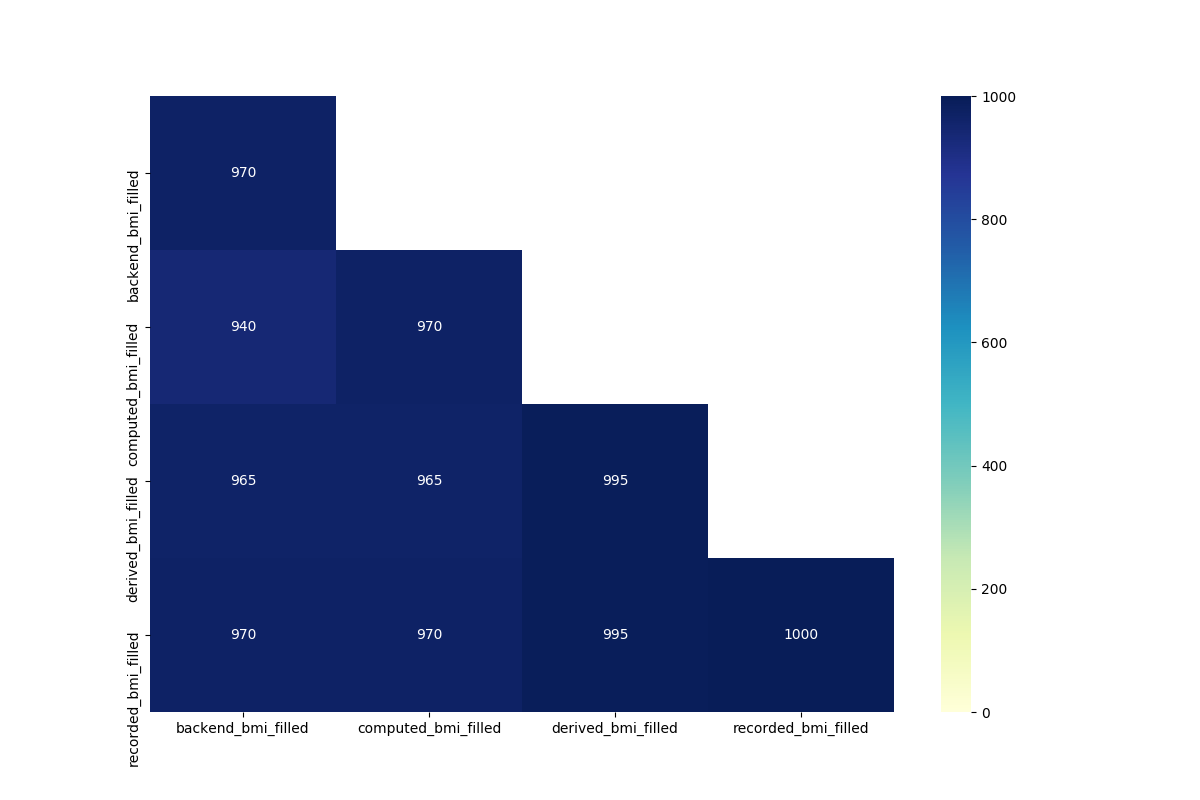

In [5]:
display(Image(f"../output/{output_path}/figures/heatmap.png"))

### Distribution of Values

#### Comparison of Distributions

mean  count
backend_bmi   25.841188   3000
computed_bmi  25.760556   2985
derived_bmi   27.844921   4575
recorded_bmi  21.959392   6850

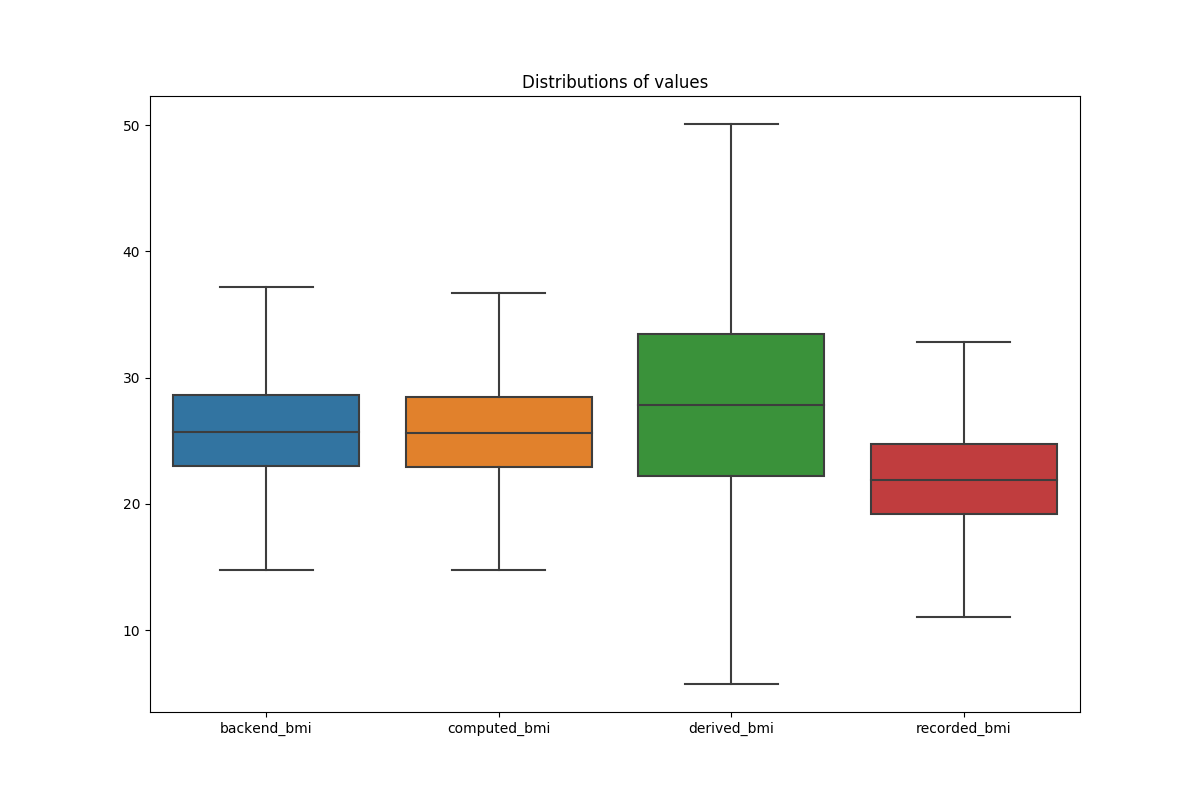

avg_backend_bmi  avg_computed_bmi  avg_derived_bmi  \
age_band                                                       
0-19            25.778759         25.838907        27.792550   
20-29           25.830126         25.622424        27.162073   
30-39           26.013982         25.631275        27.470145   
40-49           26.136526         25.508475        27.838517   
50-59           25.275990         25.749585        28.360755   
60-69           25.902199         25.839193        28.267725   
70-79           25.935698         25.724768        27.870683   
80+             25.818660         26.108908        27.994049   

          avg_recorded_bmi  ct_backend_bmi  ct_computed_bmi  ct_derived_bmi  \
age_band                                                                      
0-19             21.977565             380              365             540   
20-29            21.621698             385              405             595   
30-39            22.062344             370              350             565   
40-49            21.996956             395              365             575   
50-59            21.777414             345              335             535   
60-69            22.125030             345              420             630   
70-79            22.129886             330              325             490   
80+              22.000645             450              425             640   

          ct_recorded_bmi  
age_band                   
0-19                  845  
20-29                 890  
30-39                 860  
40-49                 865  
50-59                 815  
60-69                 890  
70-79                 750  
80+                   935

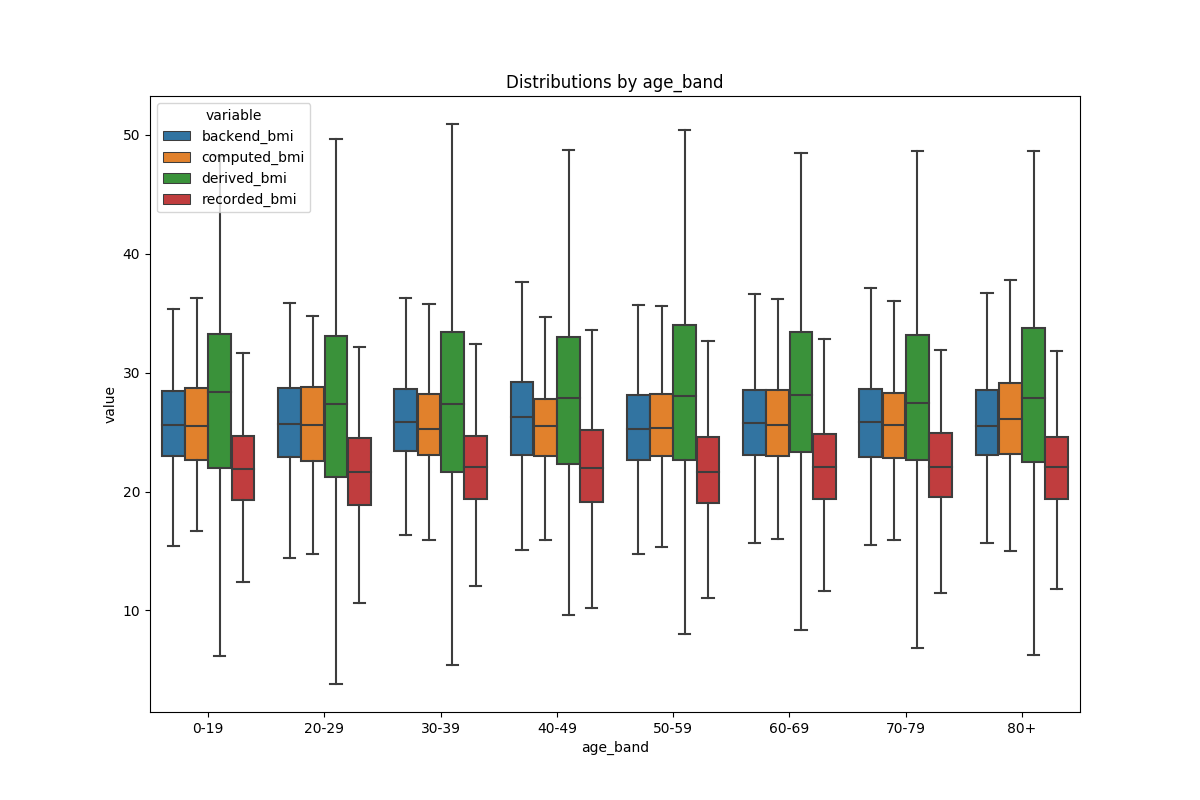

avg_backend_bmi  avg_computed_bmi  avg_derived_bmi  avg_recorded_bmi  \
sex                                                                         
F          25.826712         25.718227        27.783169         21.990612   
M          25.854894         25.799693        27.903902         21.929917   

     ct_backend_bmi  ct_computed_bmi  ct_derived_bmi  ct_recorded_bmi  
sex                                                                    
F              1460             1435            2235             3325  
M              1540             1550            2340             3525

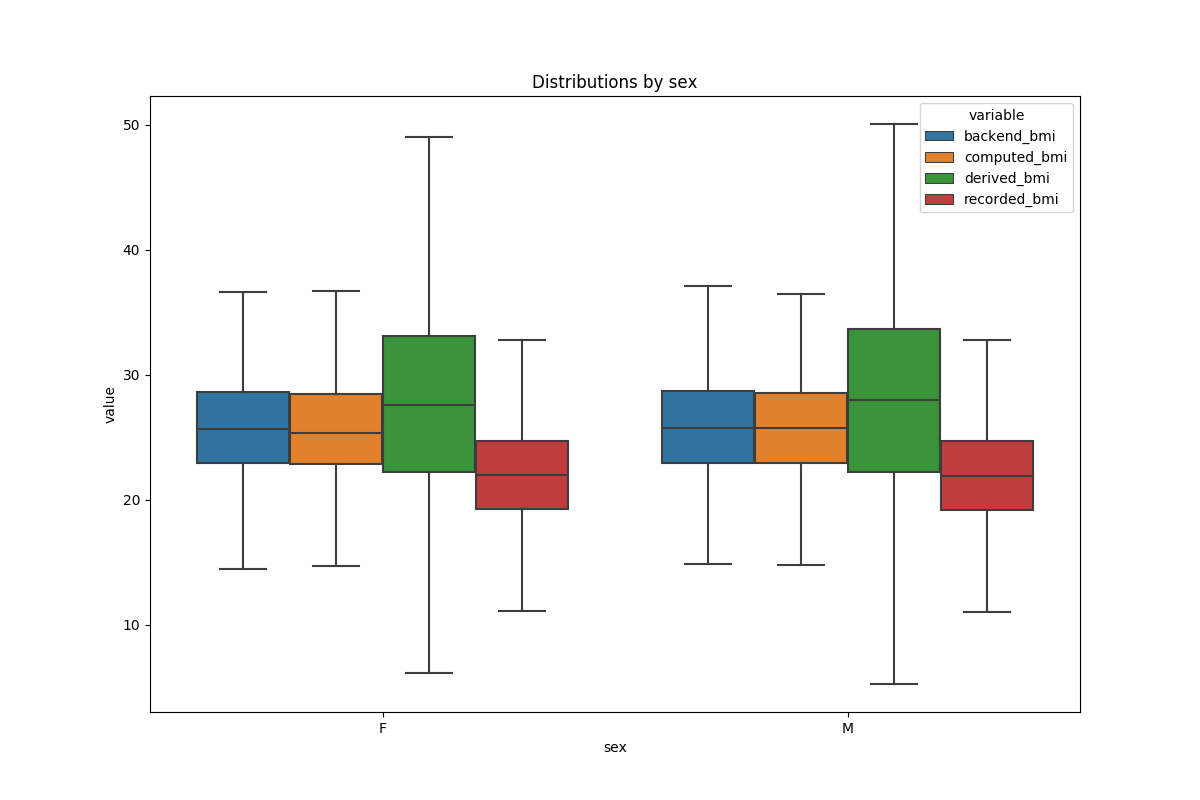

avg_backend_bmi  avg_computed_bmi  avg_derived_bmi  \
ethnicity                                                       
Asian            25.583028         25.648854        28.034250   
Black            25.436610         25.806499        27.062758   
Mixed            25.864805         25.556377        27.759203   
Other            26.108947         25.469767        27.229857   
White            25.944179         25.902190        27.978494   

           avg_recorded_bmi  ct_backend_bmi  ct_computed_bmi  ct_derived_bmi  \
ethnicity                                                                      
Asian             22.001350             445              445             690   
Black             21.814012             215              225             305   
Mixed             21.954630             715              720            1055   
Other             21.975179             105               90             185   
White             21.970241            1525             1505            2340   

           ct_recorded_bmi  
ethnicity                   
Asian                  955  
Black                  515  
Mixed                 1605  
Other                  260  
White                 3515

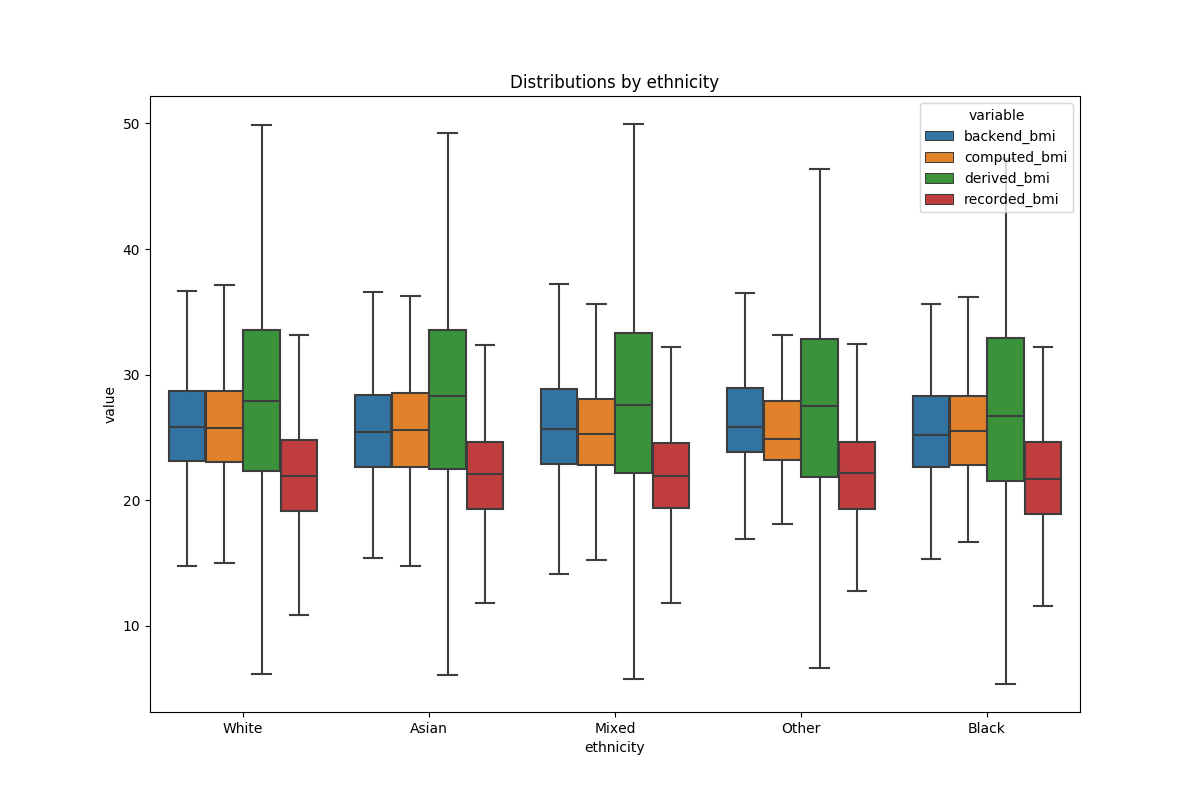

avg_backend_bmi  avg_computed_bmi  avg_derived_bmi  \
region                                                                         
East Midlands                   26.267703         25.859576        28.347028   
East of England                 25.705908         26.228079        28.828861   
London                          25.931010         25.995349        27.639245   
North East                      26.197503         25.407451        27.924048   
North West                      25.910076         25.066517        27.341754   
South East                      25.411622         25.517189        28.067489   
West Midlands                   26.211507         25.687393        27.325166   
Yorkshire and the Humber        26.142756         25.932239        28.150455   

                          avg_recorded_bmi  ct_backend_bmi  ct_computed_bmi  \
region                                                                        
East Midlands                    21.736936             185              185   
East of England                  22.271327             205              210   
London                           21.982117             395              360   
North East                       22.147984             170              200   
North West                       22.094313             220              245   
South East                       21.922001             340              335   
West Midlands                    22.298052             225              205   
Yorkshire and the Humber         21.892173             215              225   

                          ct_derived_bmi  ct_recorded_bmi  
region                                                     
East Midlands                        285              445  
East of England                      290              420  
London                               560              845  
North East                           295              460  
North West                           385              550  
South East                           495              745  
West Midlands                        325              470  
Yorkshire and the Humber             330              480

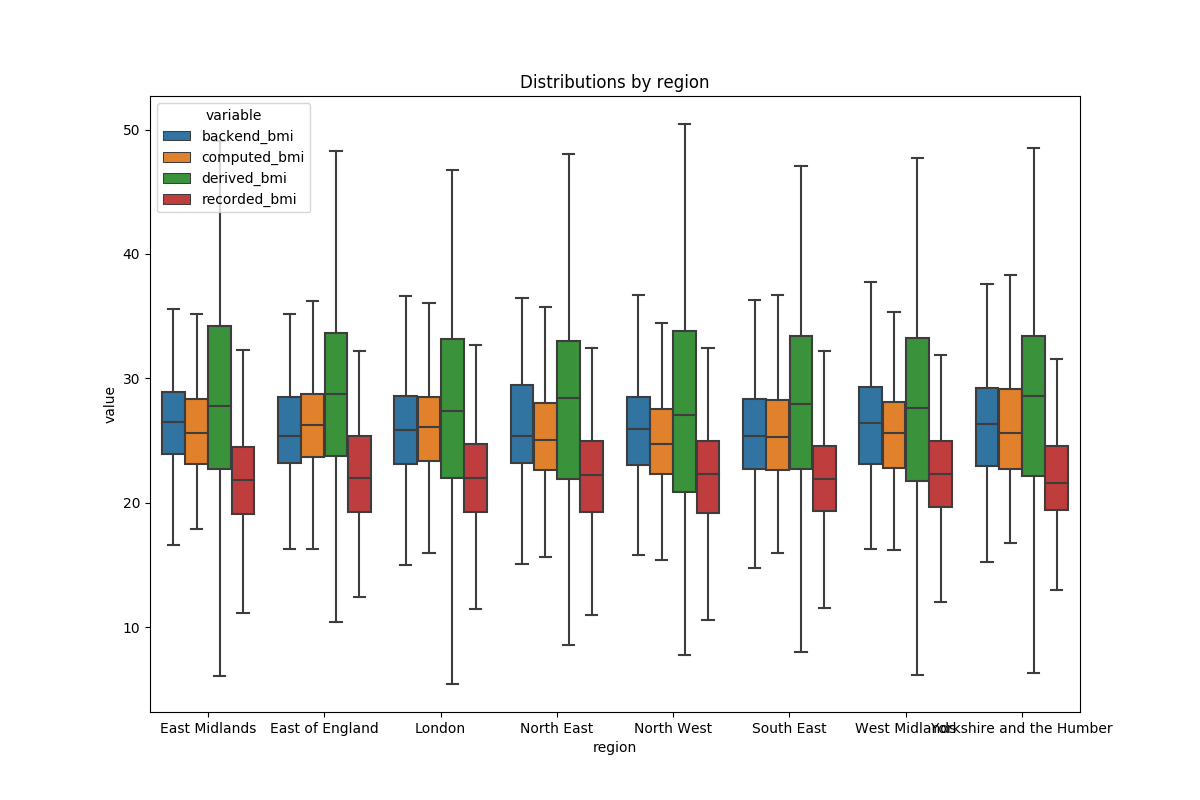

avg_backend_bmi  avg_computed_bmi  avg_derived_bmi  \
imd                                                                    
1 Most deprived         25.662142         25.766953        28.088819   
2                       25.961220         25.799589        27.815814   
3                       25.784852         25.810836        27.729451   
4                       26.027267         25.761945        27.343082   
5 Least deprived        25.766019         25.641367        28.360605   
Unknown                 25.844512         25.690135        26.716323   

                  avg_recorded_bmi  ct_backend_bmi  ct_computed_bmi  \
imd                                                                   
1 Most deprived          22.021699             615              600   
2                        21.934232             630              640   
3                        22.019437             630              665   
4                        21.996113             580              535   
5 Least deprived         21.800812             510              505   
Unknown                  22.031619              30               40   

                  ct_derived_bmi  ct_recorded_bmi  
imd                                                
1 Most deprived              865             1340  
2                            995             1480  
3                           1000             1475  
4                            855             1300  
5 Least deprived             810             1185  
Unknown                       50               75

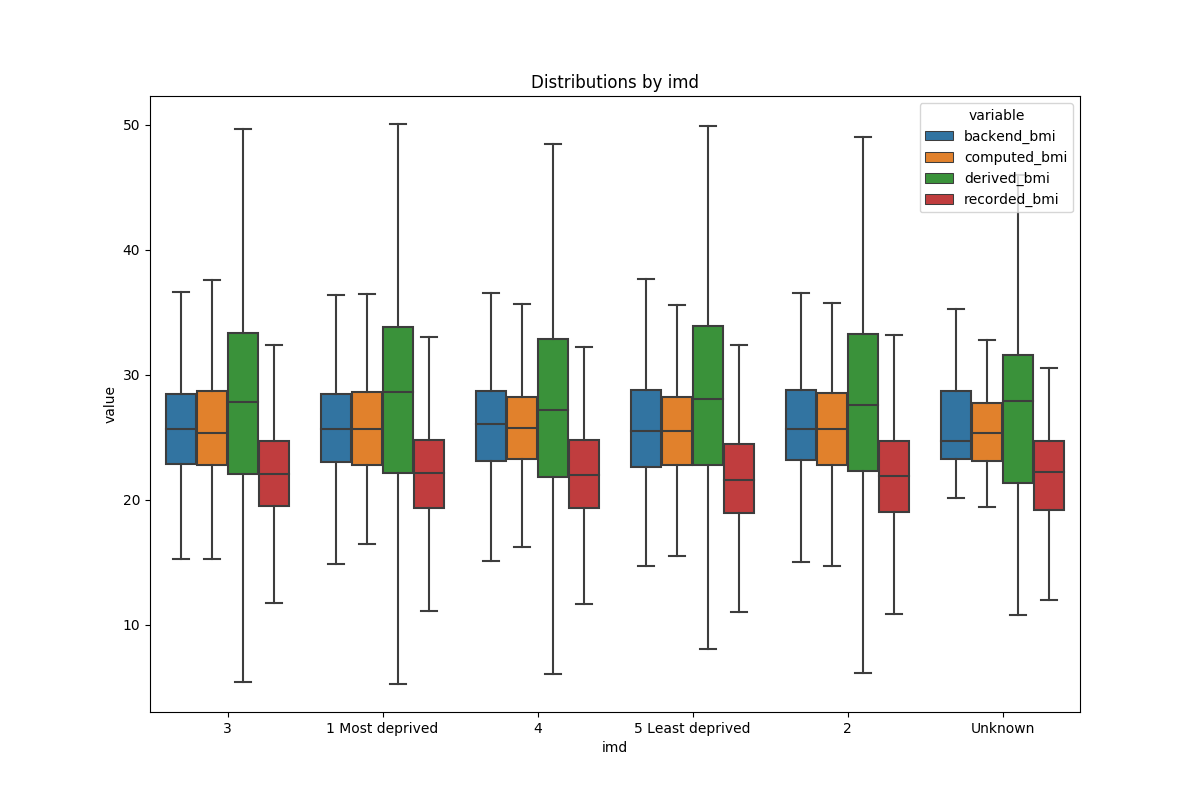

avg_backend_bmi  avg_computed_bmi  avg_derived_bmi  \
dementia                                                       
False           25.847915         25.774482        27.831839   
True            25.151509         24.341158        29.105257   

          avg_recorded_bmi  ct_backend_bmi  ct_computed_bmi  ct_derived_bmi  \
dementia                                                                      
False            21.959531            2975             2955            4530   
True             21.944582              30               30              45   

          ct_recorded_bmi  
dementia                   
False                6785  
True                   65

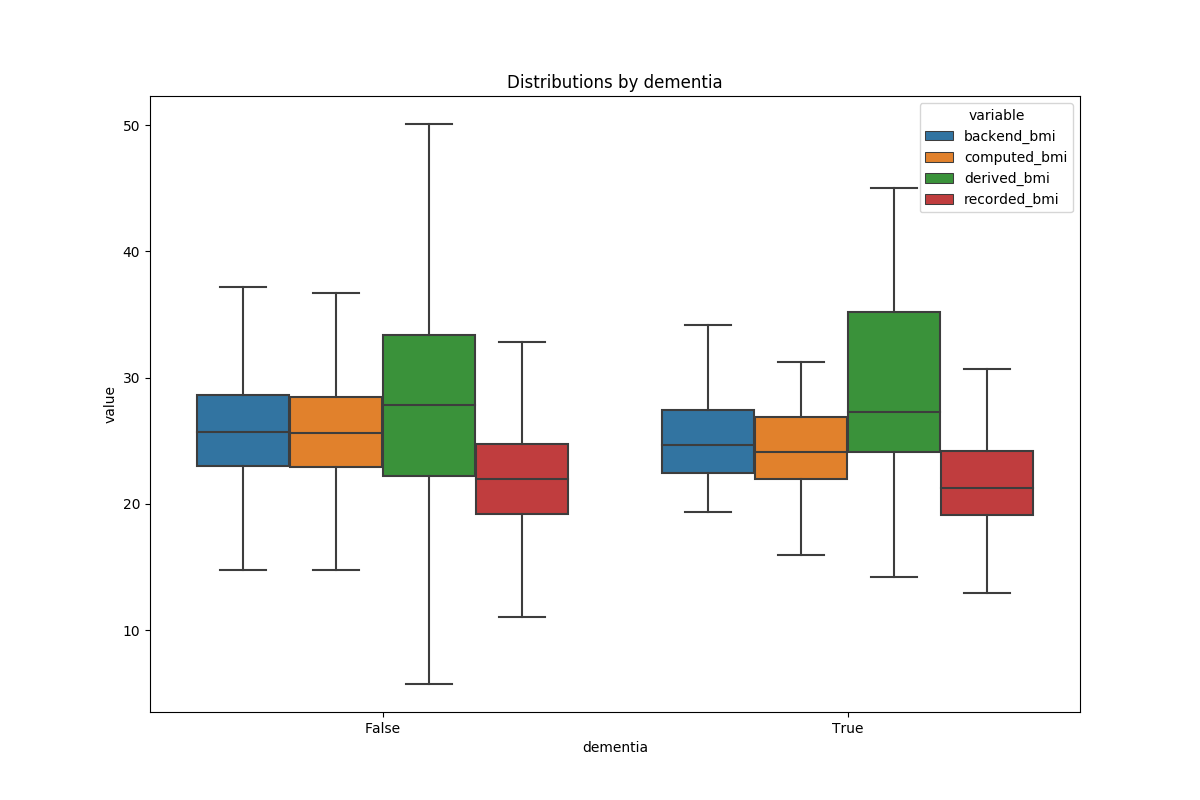

avg_backend_bmi  avg_computed_bmi  avg_derived_bmi  \
diabetes                                                       
False           25.837625          25.75957        27.839633   
True            26.182632          25.86473        28.511604   

          avg_recorded_bmi  ct_backend_bmi  ct_computed_bmi  ct_derived_bmi  \
diabetes                                                                      
False            21.963613            2970             2955            4540   
True             21.572919              30               30              35   

          ct_recorded_bmi  
diabetes                   
False                6775  
True                   75

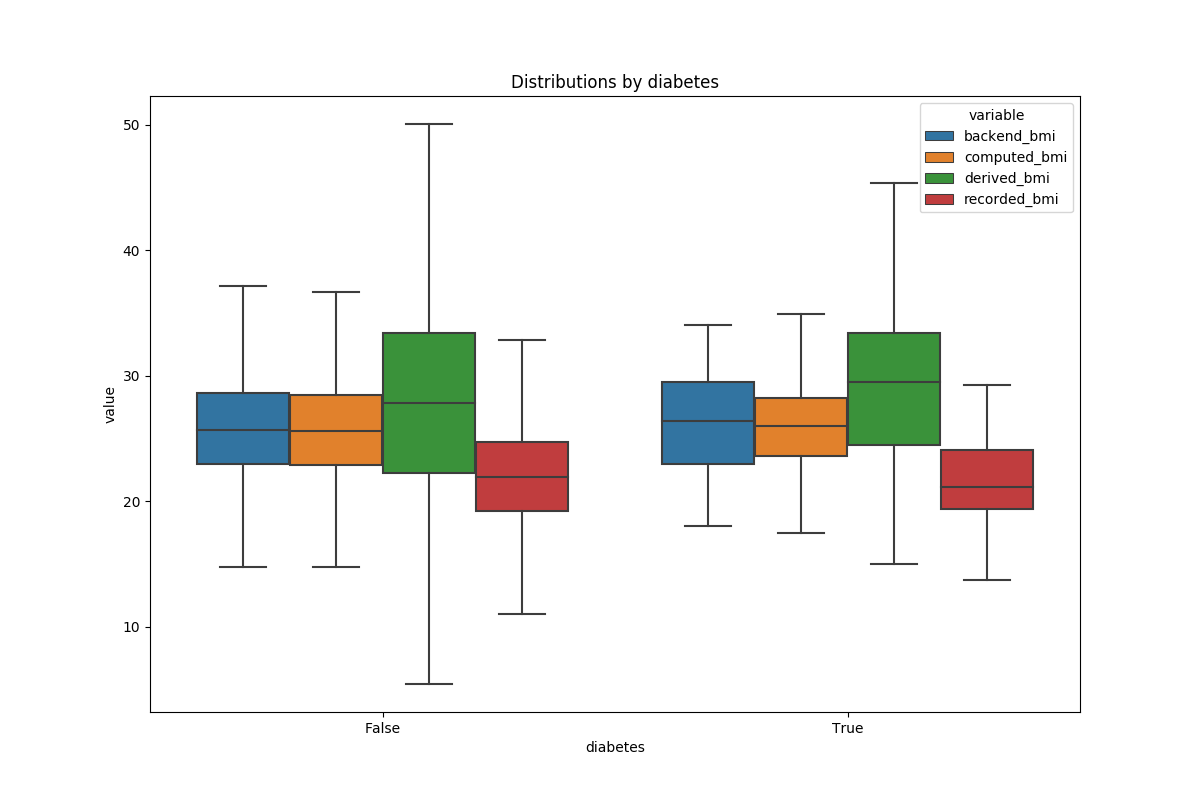

avg_backend_bmi  avg_computed_bmi  avg_derived_bmi  \
hypertension                                                       
False               25.835593         25.767056        27.833371   
True                26.457620         25.098059        28.934245   

              avg_recorded_bmi  ct_backend_bmi  ct_computed_bmi  \
hypertension                                                      
False                21.957901            2975             2955   
True                 22.103763              25               30   

              ct_derived_bmi  ct_recorded_bmi  
hypertension                                   
False                   4525             6780  
True                      50               70

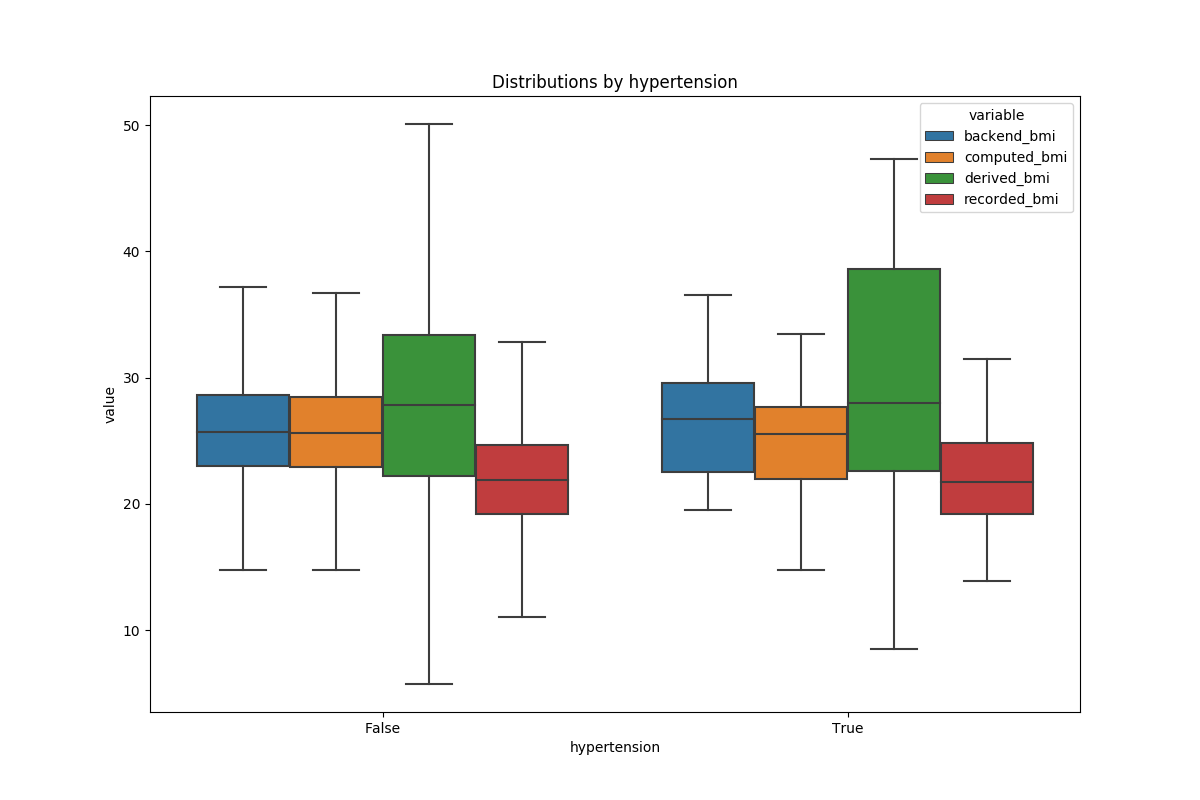

avg_backend_bmi  avg_computed_bmi  avg_derived_bmi  \
learning_disability                                                       
False                      25.847457         25.757109        27.835976   
True                       25.094712         26.204472        28.745415   

                     avg_recorded_bmi  ct_backend_bmi  ct_computed_bmi  \
learning_disability                                                      
False                       21.955430            2975             2960   
True                        22.348624              25               25   

                     ct_derived_bmi  ct_recorded_bmi  
learning_disability                                   
False                          4530             6780  
True                             45               70

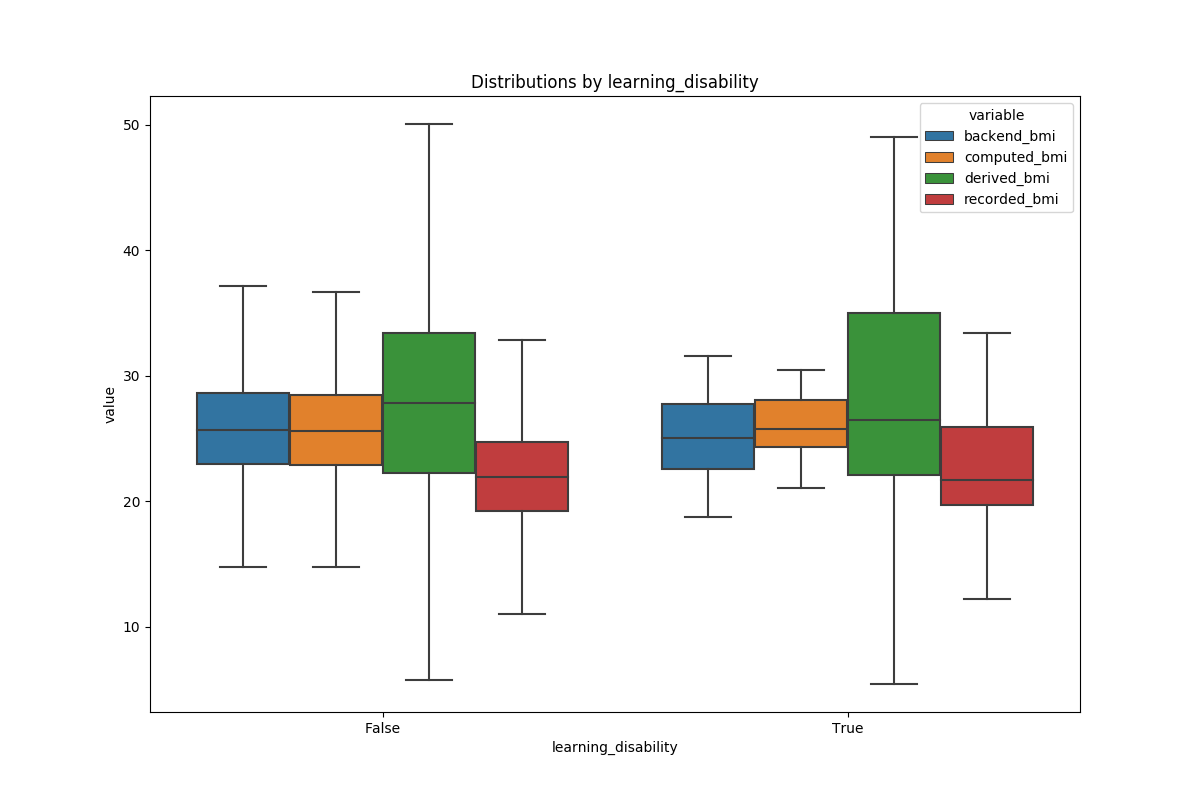

In [6]:
for suffix in [''] + covariates:    
    df_distribution = pd.read_csv(f'../output/{output_path}/tables/avg_value{suffix}.csv', index_col=0)
    display(df_distribution)
    
    img_exist = os.path.exists(f'../output/{output_path}/figures/distribution{suffix}.png')
    
    if img_exist:
        img_distribution = Image(f'../output/{output_path}/figures/distribution{suffix}.png')
        display(img_distribution)
    else: 
        print('Plot redacted due to low counts.')

#### Out-of-Range Values

oor_backend_bmi oor_computed_bmi oor_derived_bmi oor_recorded_bmi
index                                                                  
count               -                -               -                -
mean                -                -               -                -
pct25               -                -               -                -
pct75               -                -               -                -

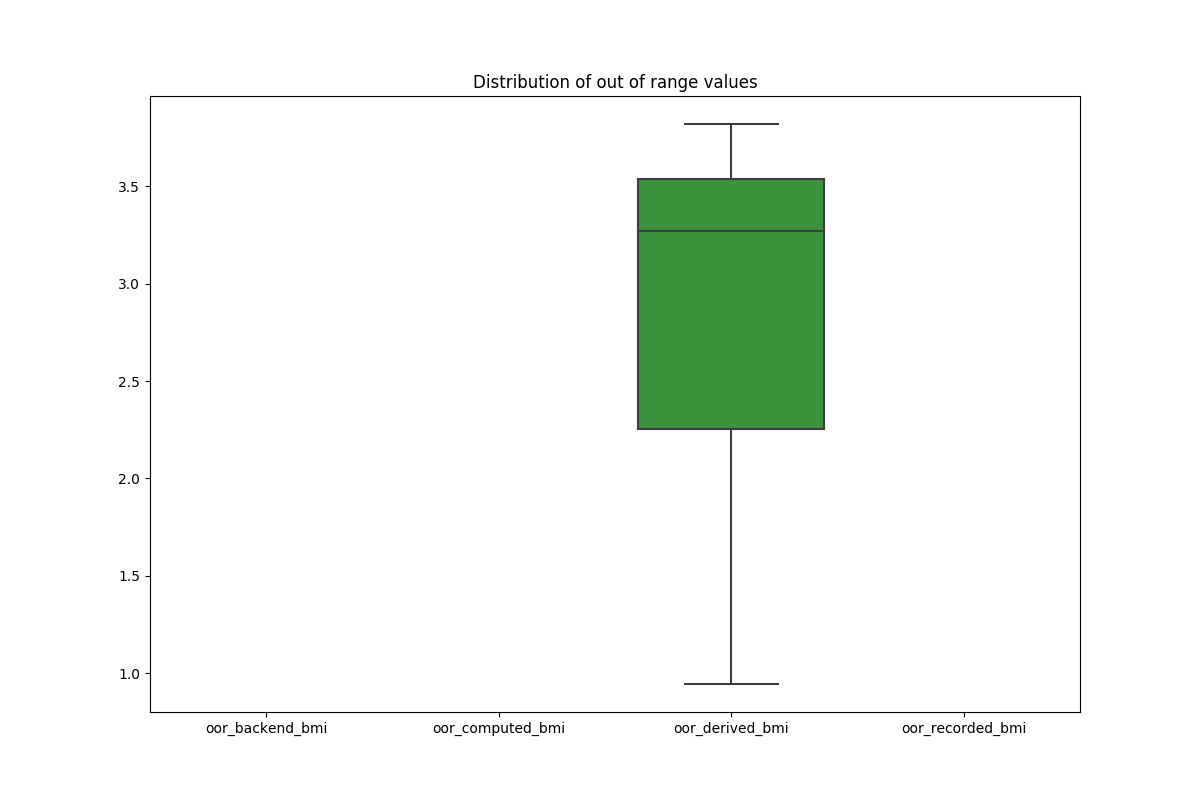

count_backend_bmi mean_backend_bmi pct25_backend_bmi  \
age_band                                                        
0-19                     -                -                 -   
20-29                    -                -                 -   
30-39                    -                -                 -   
40-49                    -                -                 -   
50-59                    -                -                 -   
60-69                    -                -                 -   
70-79                    -                -                 -   
80+                      -                -                 -   

         pct75_backend_bmi count_computed_bmi mean_computed_bmi  \
age_band                                                          
0-19                     -                  -                 -   
20-29                    -                  -                 -   
30-39                    -                  -                 -   
40-49                    -                  -                 -   
50-59                    -                  -                 -   
60-69                    -                  -                 -   
70-79                    -                  -                 -   
80+                      -                  -                 -   

         pct25_computed_bmi pct75_computed_bmi count_derived_bmi  \
age_band                                                           
0-19                      -                  -                 -   
20-29                     -                  -                 -   
30-39                     -                  -                 -   
40-49                     -                  -                 -   
50-59                     -                  -                 -   
60-69                     -                  -                 -   
70-79                     -                  -                 -   
80+                       -                  -                 -   

         mean_derived_bmi pct25_derived_bmi pct75_derived_bmi  \
age_band                                                        
0-19                    -                 -                 -   
20-29                   -                 -                 -   
30-39                   -                 -                 -   
40-49                   -                 -                 -   
50-59                   -                 -                 -   
60-69                   -                 -                 -   
70-79                   -                 -                 -   
80+                     -                 -                 -   

         count_recorded_bmi mean_recorded_bmi pct25_recorded_bmi  \
age_band                                                           
0-19                      -                 -                  -   
20-29                     -                 -                  -   
30-39                     -                 -                  -   
40-49                     -                 -                  -   
50-59                     -                 -                  -   
60-69                     -                 -                  -   
70-79                     -                 -                  -   
80+                       -                 -                  -   

         pct75_recorded_bmi  
age_band                     
0-19                      -  
20-29                     -  
30-39                     -  
40-49                     -  
50-59                     -  
60-69                     -  
70-79                     -  
80+                       -

Plot redacted due to low counts.


count_backend_bmi mean_backend_bmi pct25_backend_bmi pct75_backend_bmi  \
sex                                                                          
F                   -                -                 -                 -   
M                   -                -                 -                 -   

    count_computed_bmi mean_computed_bmi pct25_computed_bmi  \
sex                                                           
F                    -                 -                  -   
M                    -                 -                  -   

    pct75_computed_bmi count_derived_bmi mean_derived_bmi pct25_derived_bmi  \
sex                                                                           
F                    -                 -                -                 -   
M                    -                 -                -                 -   

    pct75_derived_bmi count_recorded_bmi mean_recorded_bmi pct25_recorded_bmi  \
sex                                                                             
F                   -                  -                 -                  -   
M                   -                  -                 -                  -   

    pct75_recorded_bmi  
sex                     
F                    -  
M                    -

Plot redacted due to low counts.


count_backend_bmi mean_backend_bmi pct25_backend_bmi  \
ethnicity                                                        
Asian                     -                -                 -   
Black                     -                -                 -   
Mixed                     -                -                 -   
Other                     -                -                 -   
White                     -                -                 -   

          pct75_backend_bmi count_computed_bmi mean_computed_bmi  \
ethnicity                                                          
Asian                     -                  -                 -   
Black                     -                  -                 -   
Mixed                     -                  -                 -   
Other                     -                  -                 -   
White                     -                  -                 -   

          pct25_computed_bmi pct75_computed_bmi count_derived_bmi  \
ethnicity                                                           
Asian                      -                  -                 -   
Black                      -                  -                 -   
Mixed                      -                  -                 -   
Other                      -                  -                 -   
White                      -                  -                 -   

          mean_derived_bmi pct25_derived_bmi pct75_derived_bmi  \
ethnicity                                                        
Asian                    -                 -                 -   
Black                    -                 -                 -   
Mixed                    -                 -                 -   
Other                    -                 -                 -   
White                    -                 -                 -   

          count_recorded_bmi mean_recorded_bmi pct25_recorded_bmi  \
ethnicity                                                           
Asian                      -                 -                  -   
Black                      -                 -                  -   
Mixed                      -                 -                  -   
Other                      -                 -                  -   
White                      -                 -                  -   

          pct75_recorded_bmi  
ethnicity                     
Asian                      -  
Black                      -  
Mixed                      -  
Other                      -  
White                      -

Plot redacted due to low counts.


count_backend_bmi mean_backend_bmi pct25_backend_bmi  \
region                                                                          
East Midlands                            -                -                 -   
East of England                          -                -                 -   
London                                   -                -                 -   
North East                               -                -                 -   
North West                               -                -                 -   
South East                               -                -                 -   
West Midlands                            -                -                 -   
Yorkshire and the Humber                 -                -                 -   

                         pct75_backend_bmi count_computed_bmi  \
region                                                          
East Midlands                            -                  -   
East of England                          -                  -   
London                                   -                  -   
North East                               -                  -   
North West                               -                  -   
South East                               -                  -   
West Midlands                            -                  -   
Yorkshire and the Humber                 -                  -   

                         mean_computed_bmi pct25_computed_bmi  \
region                                                          
East Midlands                            -                  -   
East of England                          -                  -   
London                                   -                  -   
North East                               -                  -   
North West                               -                  -   
South East                               -                  -   
West Midlands                            -                  -   
Yorkshire and the Humber                 -                  -   

                         pct75_computed_bmi count_derived_bmi  \
region                                                          
East Midlands                             -                 -   
East of England                           -                 -   
London                                    -                 -   
North East                                -                 -   
North West                                -                 -   
South East                                -                 -   
West Midlands                             -                 -   
Yorkshire and the Humber                  -                 -   

                         mean_derived_bmi pct25_derived_bmi pct75_derived_bmi  \
region                                                                          
East Midlands                           -                 -                 -   
East of England                         -                 -                 -   
London                                  -                 -                 -   
North East                              -                 -                 -   
North West                              -                 -                 -   
South East                              -                 -                 -   
West Midlands                           -                 -                 -   
Yorkshire and the Humber                -                 -                 -   

                         count_recorded_bmi mean_recorded_bmi  \
region                                                          
East Midlands                             -                 -   
East of England                           -                 -   
London                                    -                 -   
North East                                -                 -   
North West                                -                 

Plot redacted due to low counts.


count_backend_bmi mean_backend_bmi pct25_backend_bmi  \
imd                                                                     
1 Most deprived                  -                -                 -   
2                                -                -                 -   
3                                -                -                 -   
4                                -                -                 -   
5 Least deprived                 -                -                 -   
Unknown                          -                -                 -   

                 pct75_backend_bmi count_computed_bmi mean_computed_bmi  \
imd                                                                       
1 Most deprived                  -                  -                 -   
2                                -                  -                 -   
3                                -                  -                 -   
4                                -                  -                 -   
5 Least deprived                 -                  -                 -   
Unknown                          -                  -                 -   

                 pct25_computed_bmi pct75_computed_bmi count_derived_bmi  \
imd                                                                        
1 Most deprived                   -                  -                 -   
2                                 -                  -                 -   
3                                 -                  -                 -   
4                                 -                  -                 -   
5 Least deprived                  -                  -                 -   
Unknown                           -                  -                 -   

                 mean_derived_bmi pct25_derived_bmi pct75_derived_bmi  \
imd                                                                     
1 Most deprived                 -                 -                 -   
2                               -                 -                 -   
3                               -                 -                 -   
4                               -                 -                 -   
5 Least deprived                -                 -                 -   
Unknown                         -                 -                 -   

                 count_recorded_bmi mean_recorded_bmi pct25_recorded_bmi  \
imd                                                                        
1 Most deprived                   -                 -                  -   
2                                 -                 -                  -   
3                                 -                 -                  -   
4                                 -                 -                  -   
5 Least deprived                  -                 -                  -   
Unknown                           -                 -                  -   

                 pct75_recorded_bmi  
imd                                  
1 Most deprived                   -  
2                                 -  
3                                 -  
4                                 -  
5 Least deprived                  -  
Unknown                           -

Plot redacted due to low counts.


count_backend_bmi mean_backend_bmi pct25_backend_bmi  \
dementia                                                        
False                    -                -                 -   
True                     -                -                 -   

         pct75_backend_bmi count_computed_bmi mean_computed_bmi  \
dementia                                                          
False                    -                  -                 -   
True                     -                  -                 -   

         pct25_computed_bmi pct75_computed_bmi count_derived_bmi  \
dementia                                                           
False                     -                  -                 -   
True                      -                  -                 -   

         mean_derived_bmi pct25_derived_bmi pct75_derived_bmi  \
dementia                                                        
False                   -                 -                 -   
True                    -                 -                 -   

         count_recorded_bmi mean_recorded_bmi pct25_recorded_bmi  \
dementia                                                           
False                     -                 -                  -   
True                      -                 -                  -   

         pct75_recorded_bmi  
dementia                     
False                     -  
True                      -

Plot redacted due to low counts.


count_backend_bmi mean_backend_bmi pct25_backend_bmi  \
diabetes                                                        
False                    -                -                 -   
True                     -                -                 -   

         pct75_backend_bmi count_computed_bmi mean_computed_bmi  \
diabetes                                                          
False                    -                  -                 -   
True                     -                  -                 -   

         pct25_computed_bmi pct75_computed_bmi count_derived_bmi  \
diabetes                                                           
False                     -                  -                 -   
True                      -                  -                 -   

         mean_derived_bmi pct25_derived_bmi pct75_derived_bmi  \
diabetes                                                        
False                   -                 -                 -   
True                    -                 -                 -   

         count_recorded_bmi mean_recorded_bmi pct25_recorded_bmi  \
diabetes                                                           
False                     -                 -                  -   
True                      -                 -                  -   

         pct75_recorded_bmi  
diabetes                     
False                     -  
True                      -

Plot redacted due to low counts.


count_backend_bmi mean_backend_bmi pct25_backend_bmi  \
hypertension                                                        
False                        -                -                 -   
True                         -                -                 -   

             pct75_backend_bmi count_computed_bmi mean_computed_bmi  \
hypertension                                                          
False                        -                  -                 -   
True                         -                  -                 -   

             pct25_computed_bmi pct75_computed_bmi count_derived_bmi  \
hypertension                                                           
False                         -                  -                 -   
True                          -                  -                 -   

             mean_derived_bmi pct25_derived_bmi pct75_derived_bmi  \
hypertension                                                        
False                       -                 -                 -   
True                        -                 -                 -   

             count_recorded_bmi mean_recorded_bmi pct25_recorded_bmi  \
hypertension                                                           
False                         -                 -                  -   
True                          -                 -                  -   

             pct75_recorded_bmi  
hypertension                     
False                         -  
True                          -

Plot redacted due to low counts.


count_backend_bmi mean_backend_bmi pct25_backend_bmi  \
learning_disability                                                        
False                               -                -                 -   
True                                -                -                 -   

                    pct75_backend_bmi count_computed_bmi mean_computed_bmi  \
learning_disability                                                          
False                               -                  -                 -   
True                                -                  -                 -   

                    pct25_computed_bmi pct75_computed_bmi count_derived_bmi  \
learning_disability                                                           
False                                -                  -                 -   
True                                 -                  -                 -   

                    mean_derived_bmi pct25_derived_bmi pct75_derived_bmi  \
learning_disability                                                        
False                              -                 -                 -   
True                               -                 -                 -   

                    count_recorded_bmi mean_recorded_bmi pct25_recorded_bmi  \
learning_disability                                                           
False                                -                 -                  -   
True                                 -                 -                  -   

                    pct75_recorded_bmi  
learning_disability                     
False                                -  
True                                 -

Plot redacted due to low counts.


In [7]:
for suffix in [''] + covariates: 
    df_oor = pd.read_csv(f'../output/{output_path}/tables/out_of_range{suffix}.csv', index_col=0)
    display(df_oor)
    
    img_exist = os.path.exists(f'../output/{output_path}/figures/out_of_range{suffix}.png')
    
    if img_exist:
        img_oor = Image(f'../output/{output_path}/figures/out_of_range{suffix}.png')
        display(img_oor)
    else: 
        print('Plot redacted due to low counts.')

### New Records Over Time

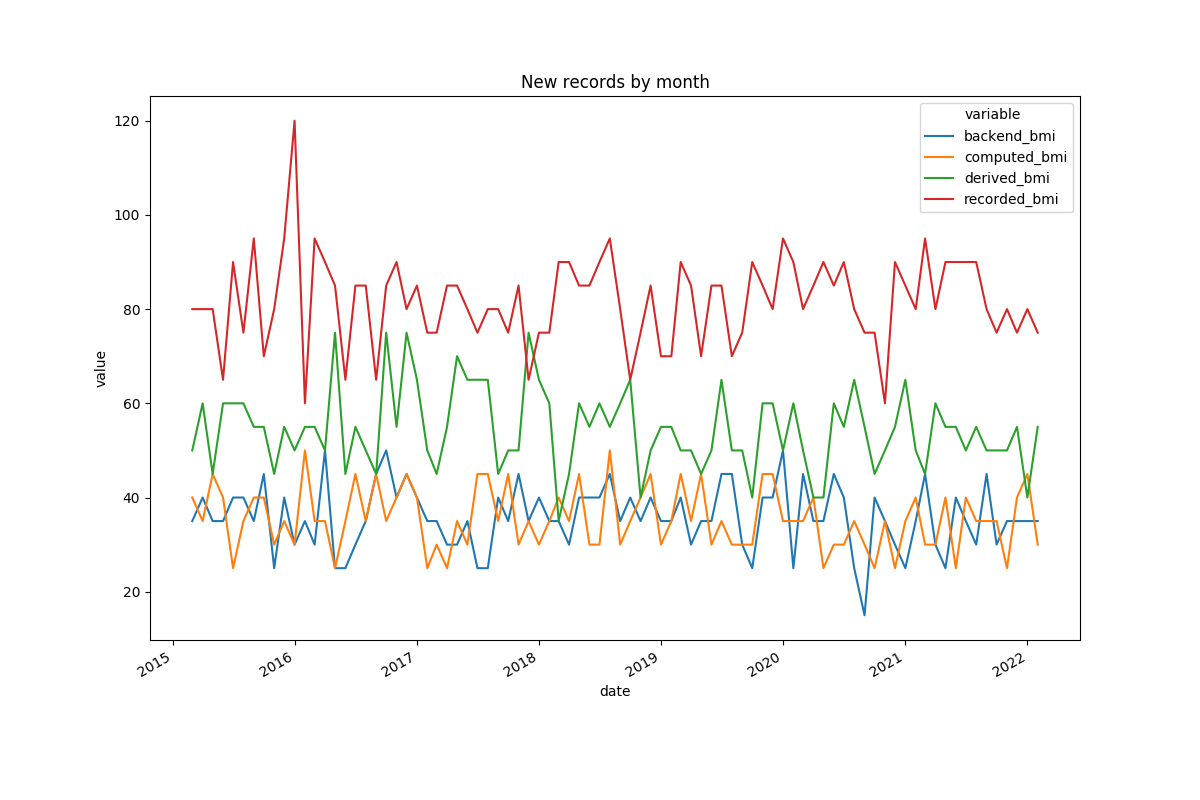

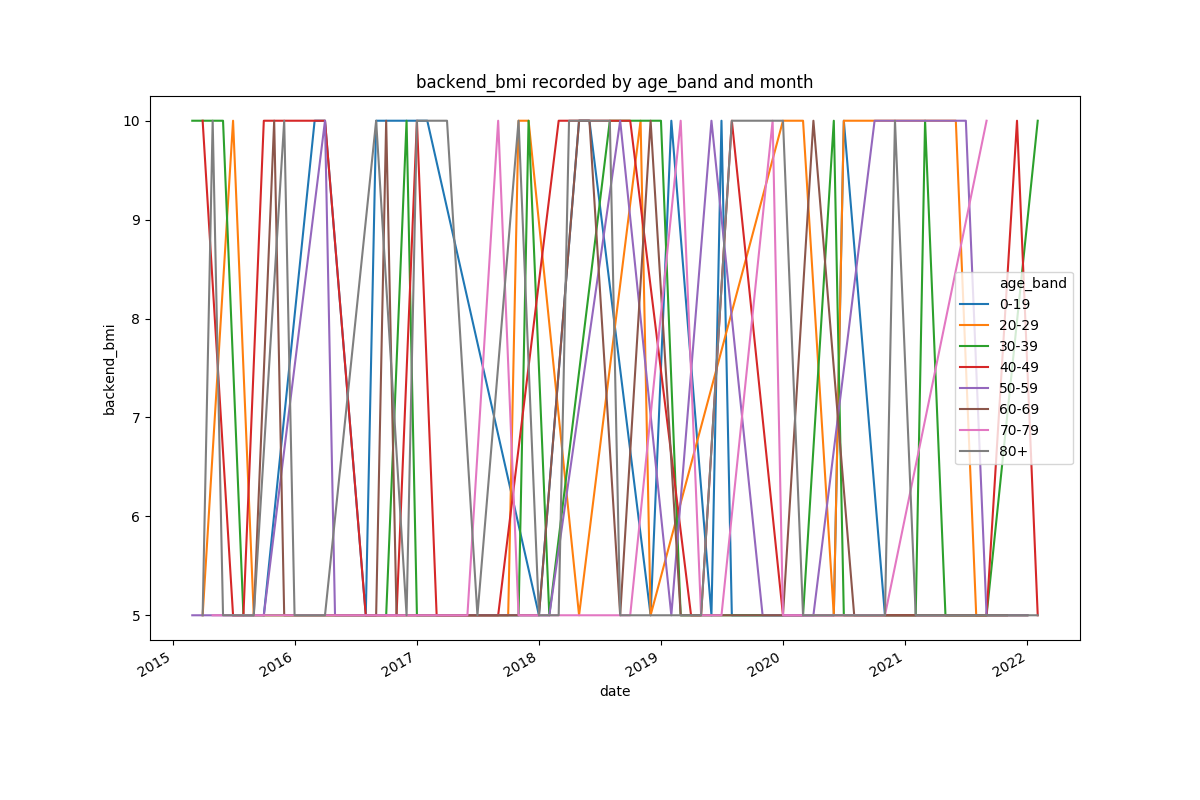

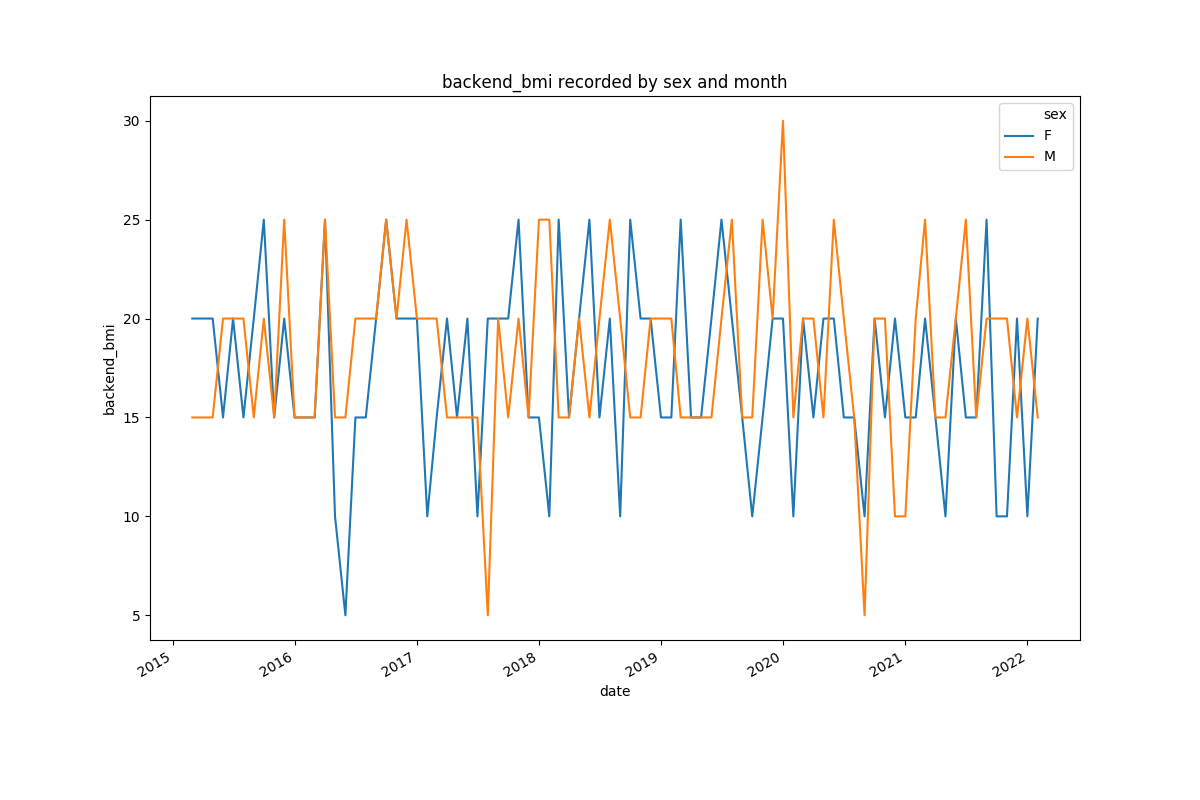

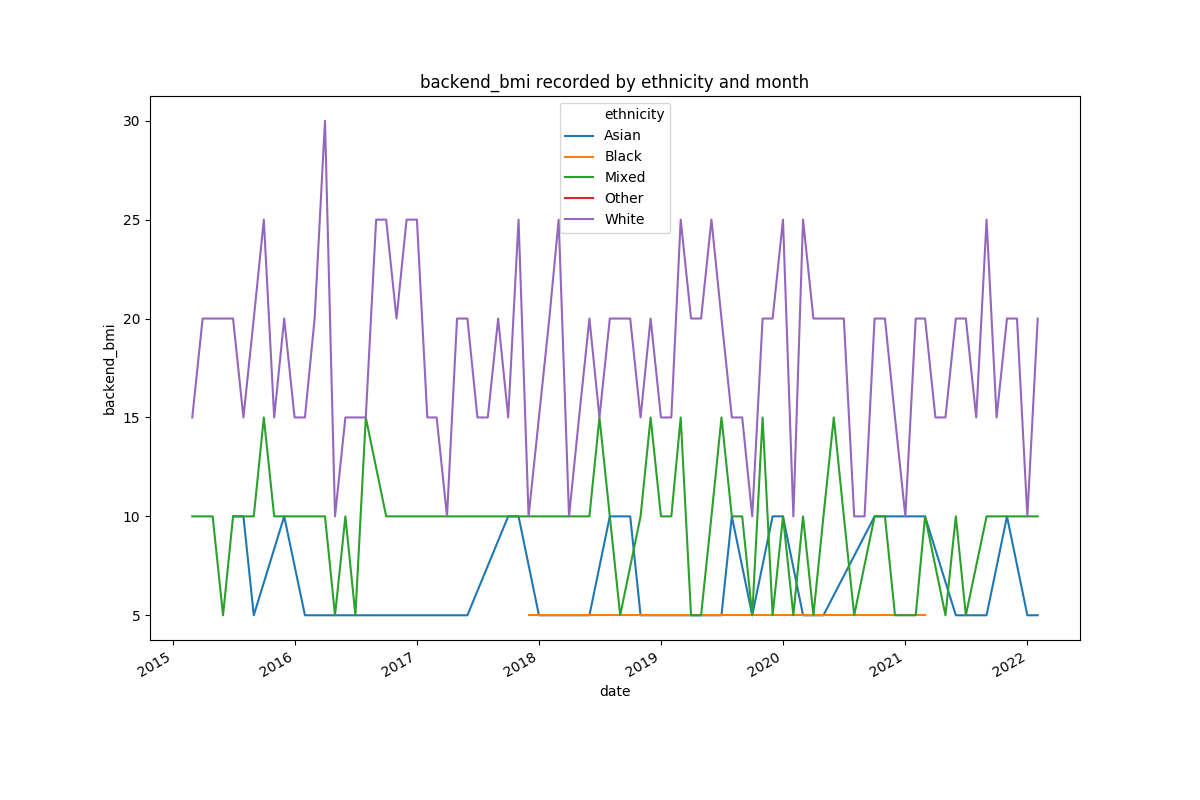

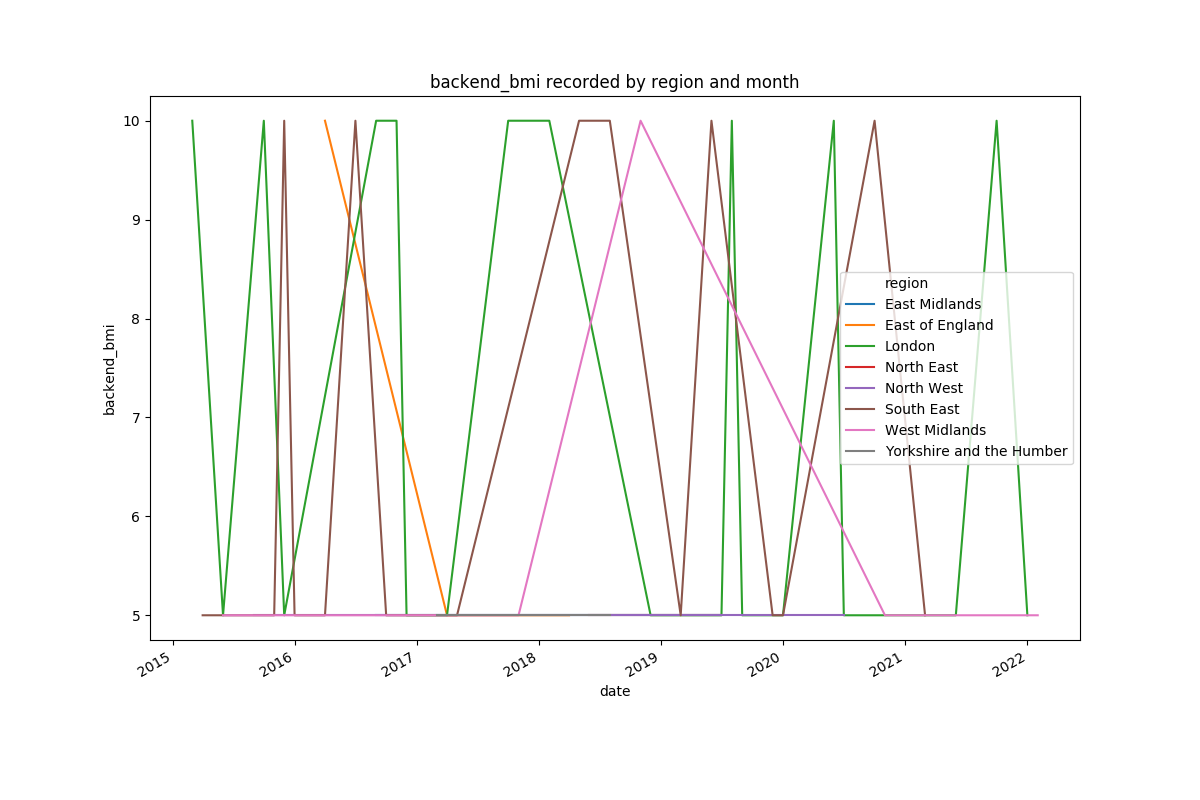

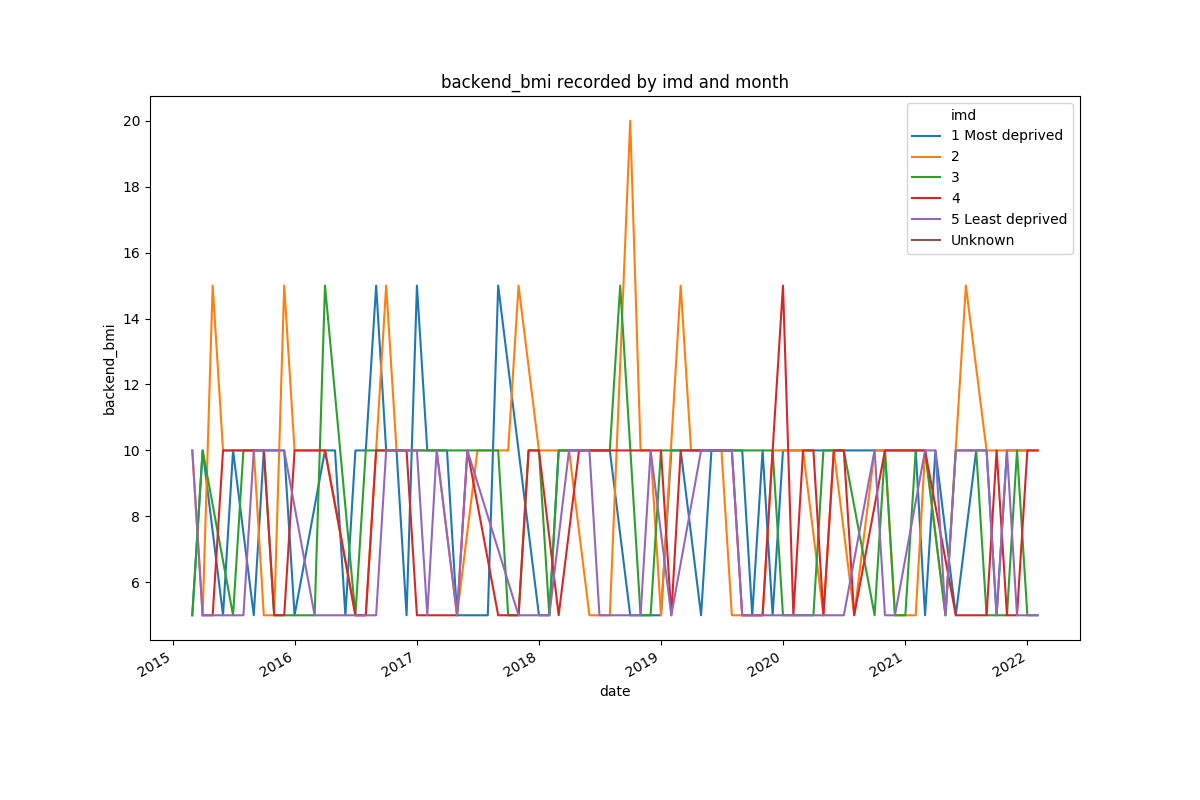

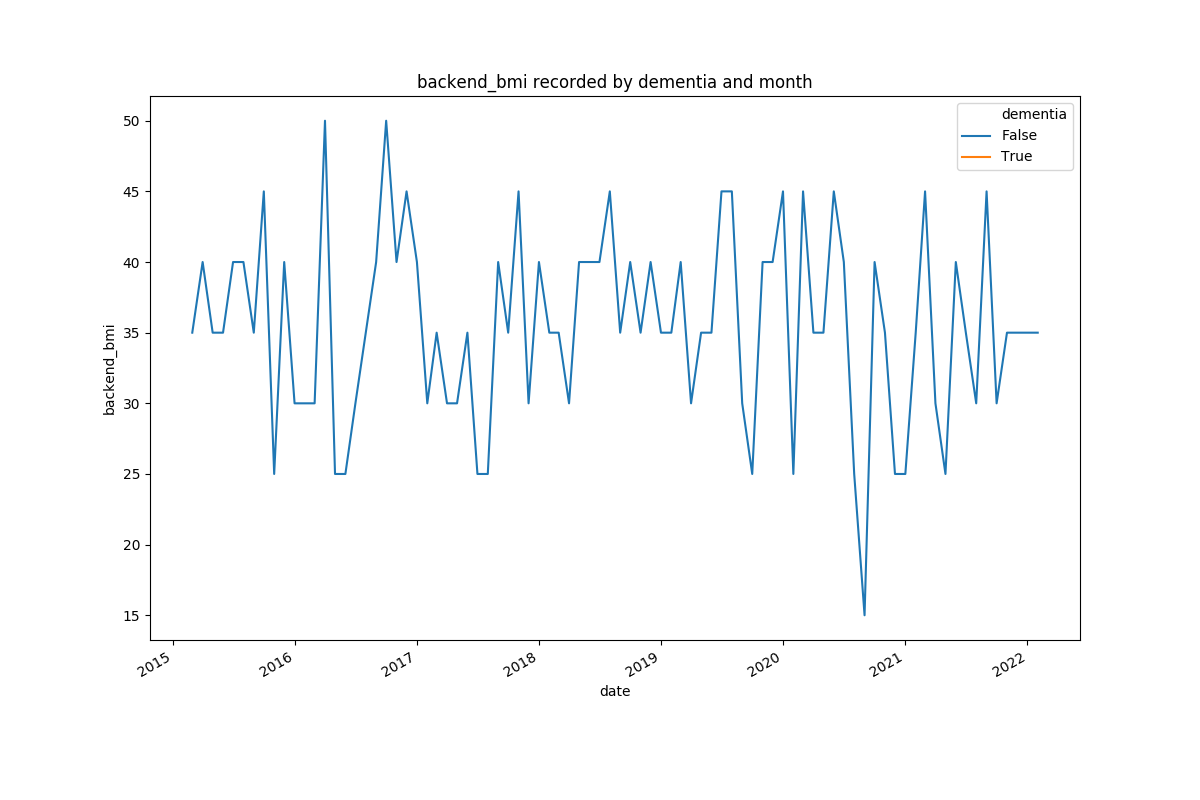

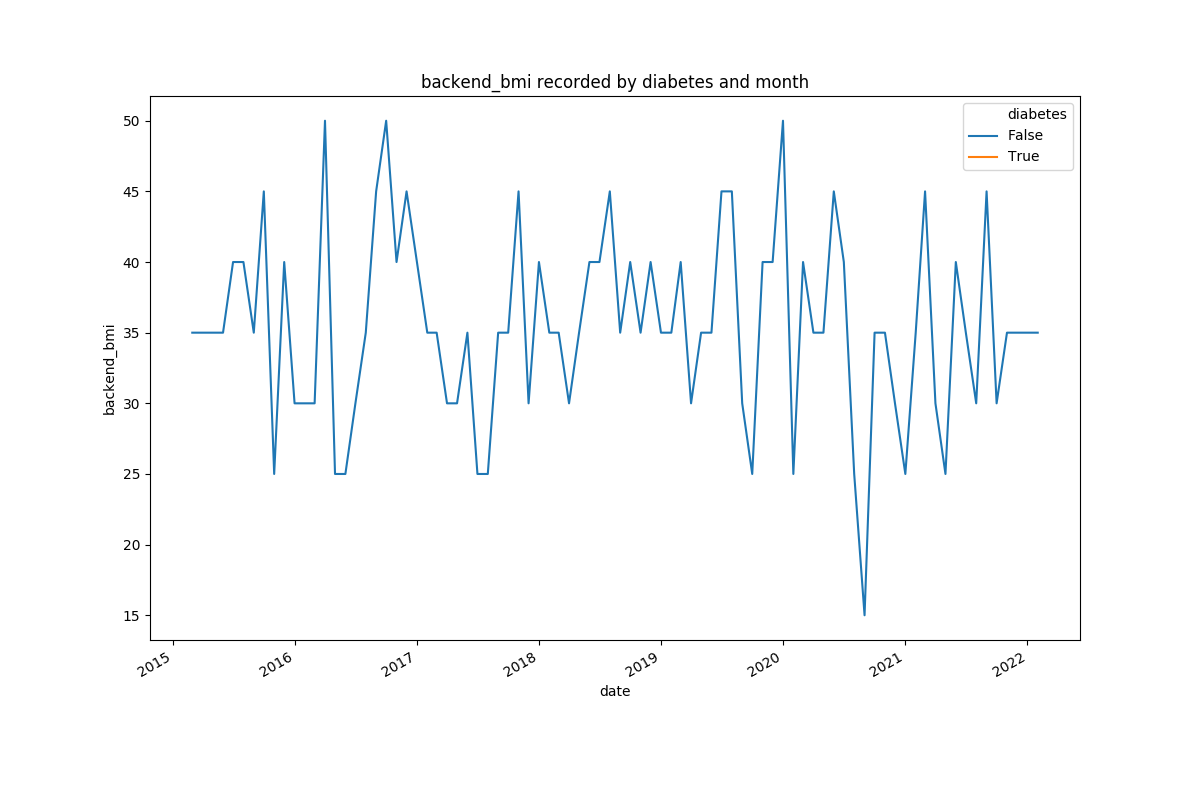

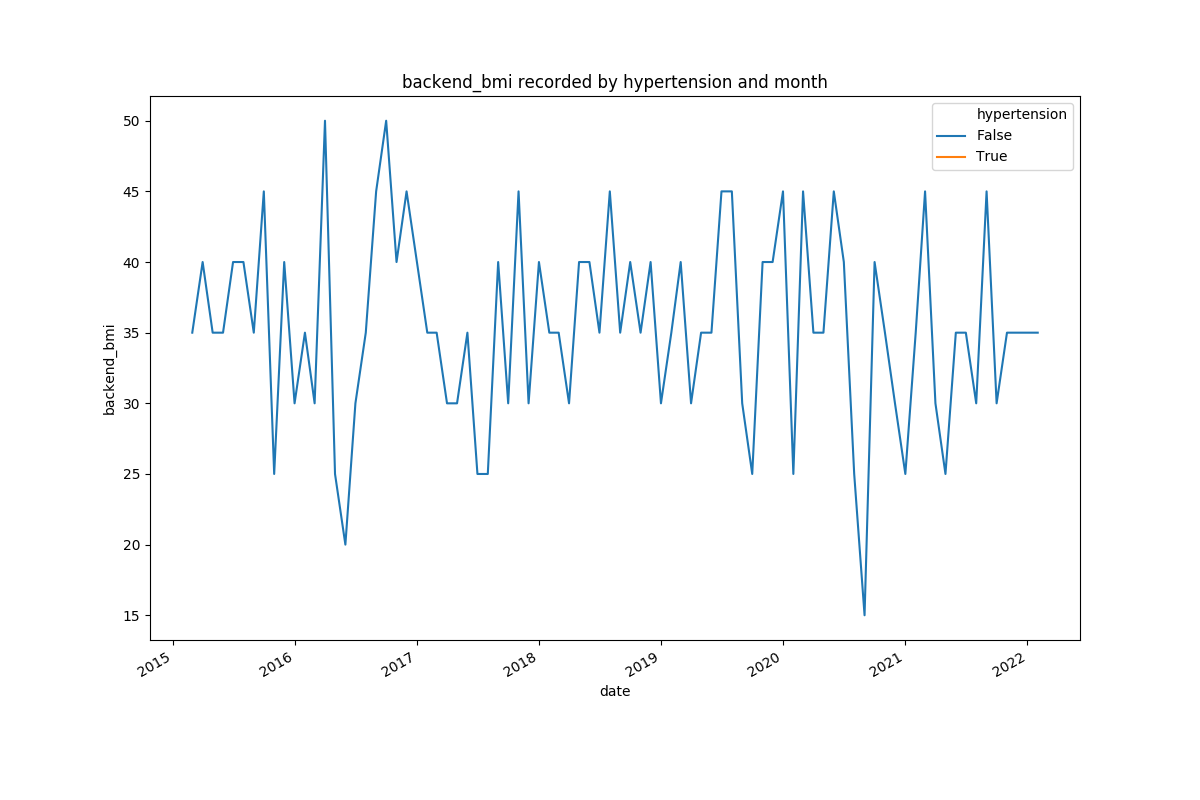

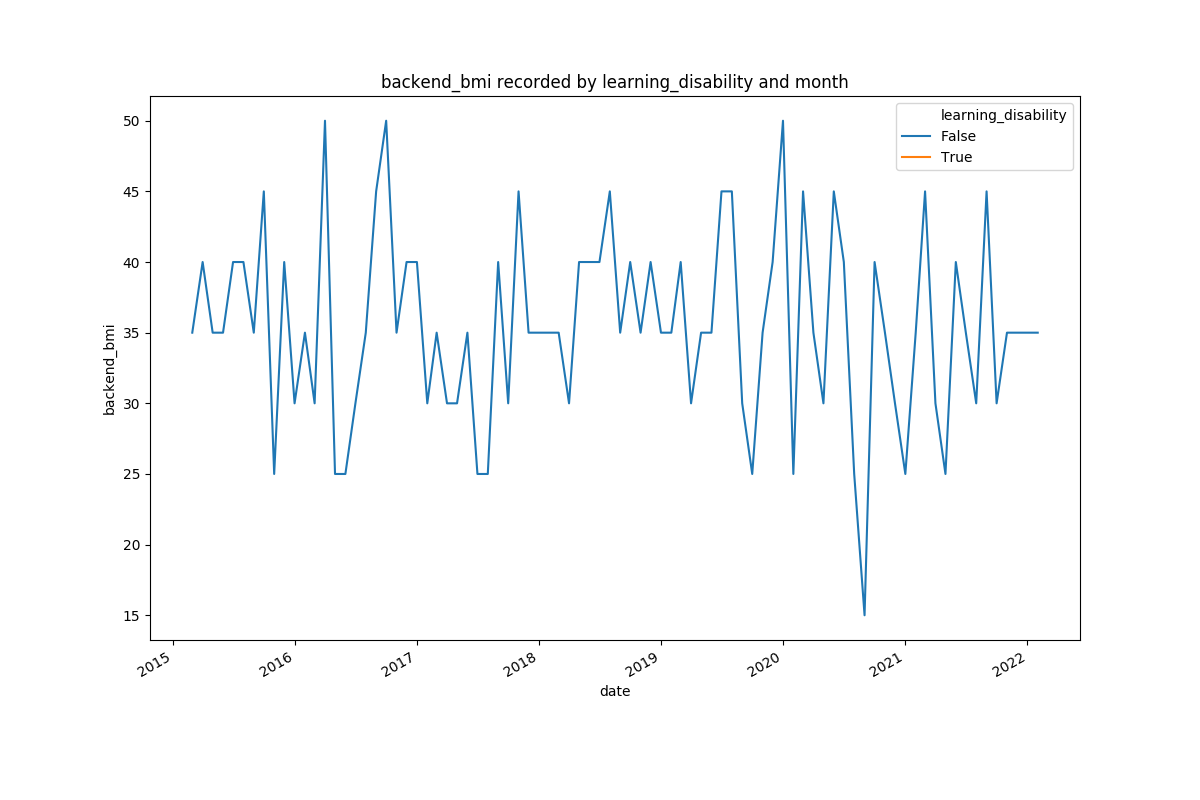

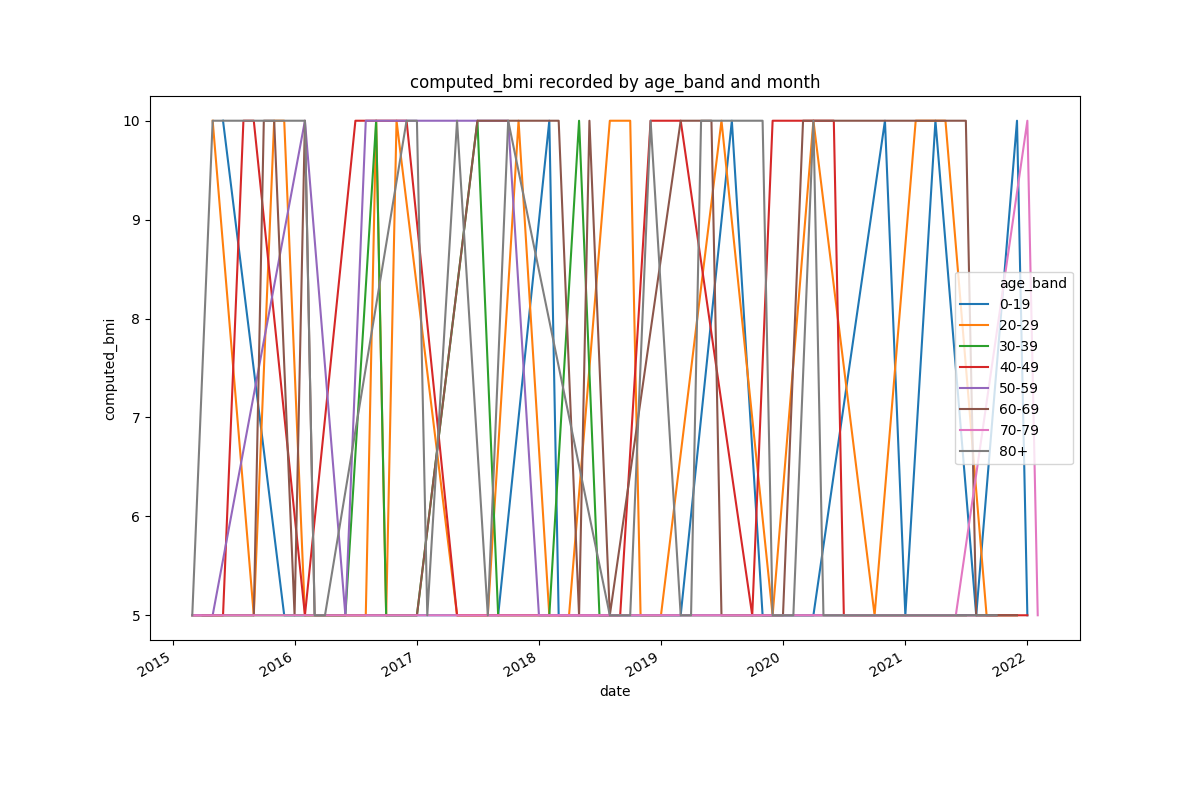

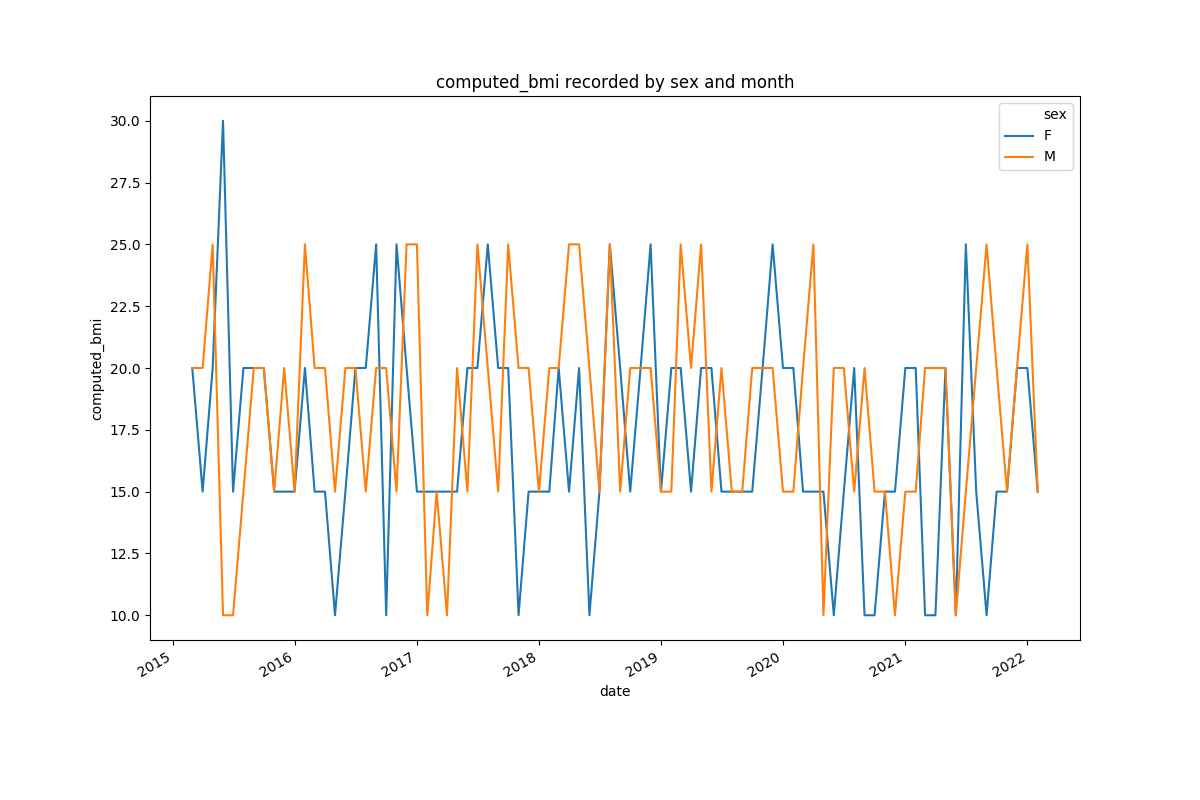

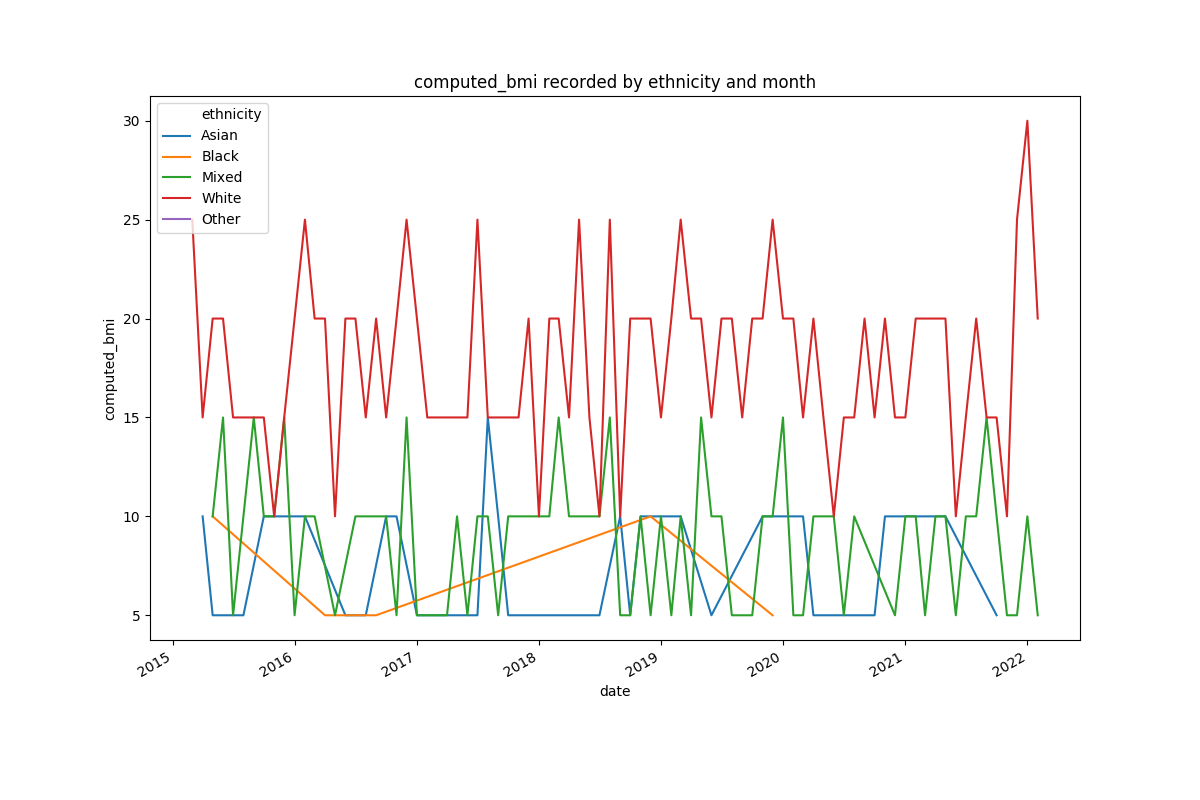

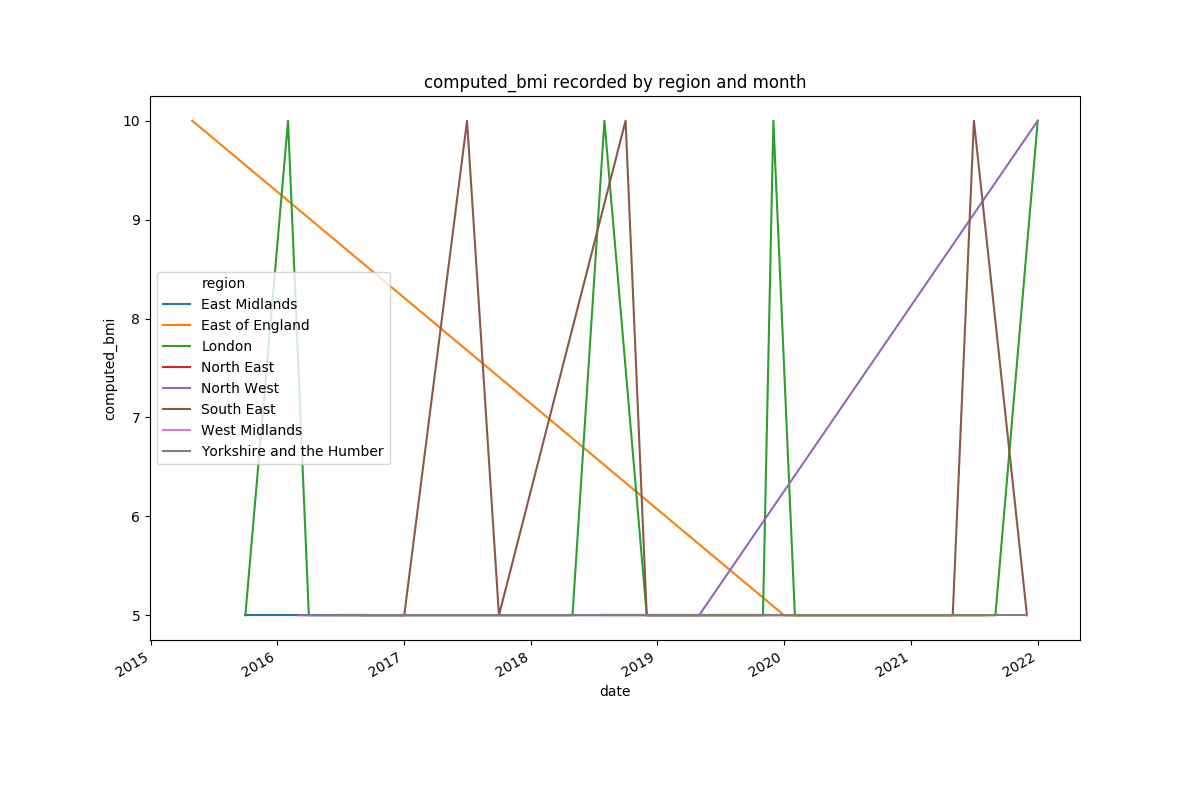

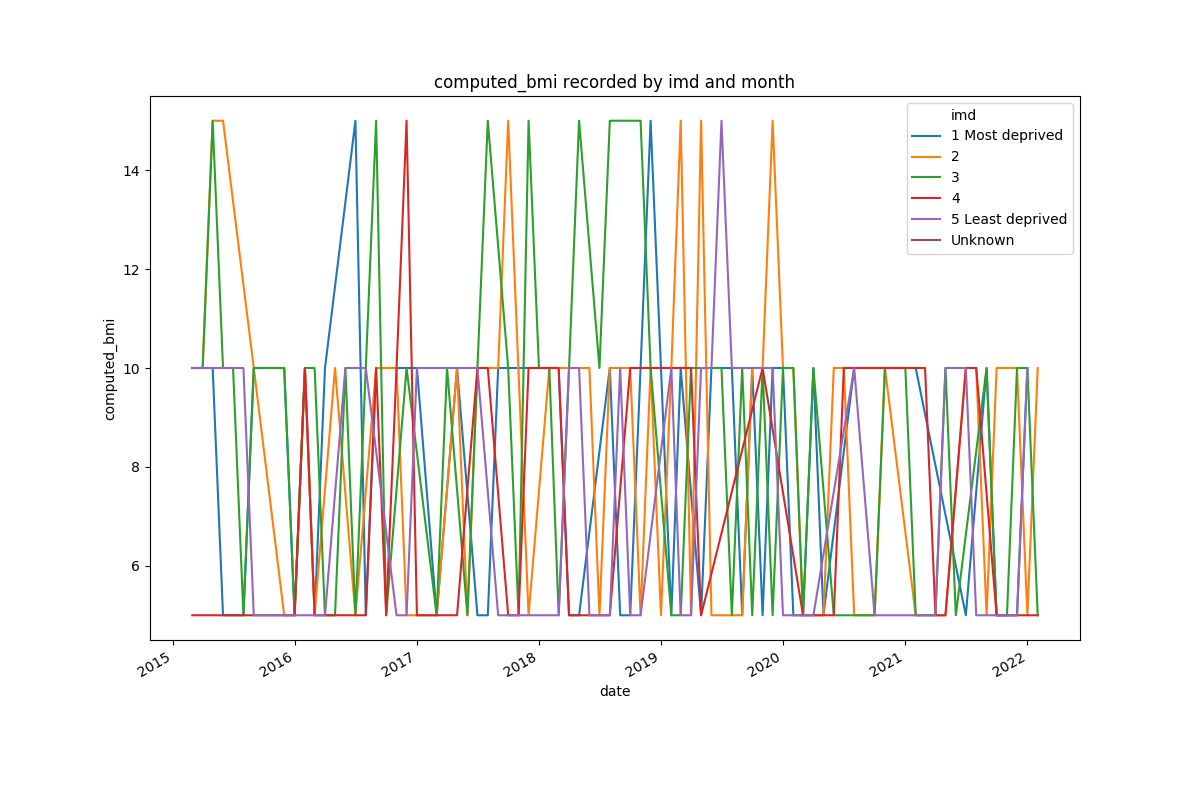

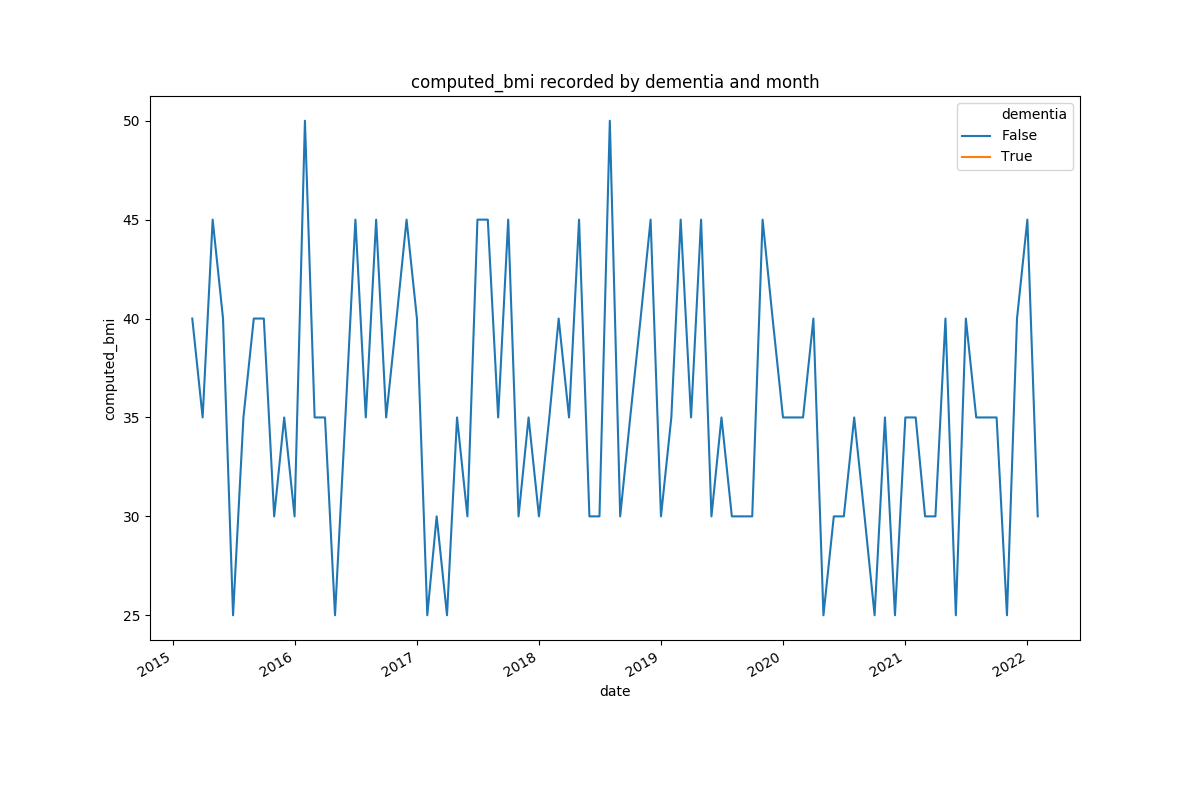

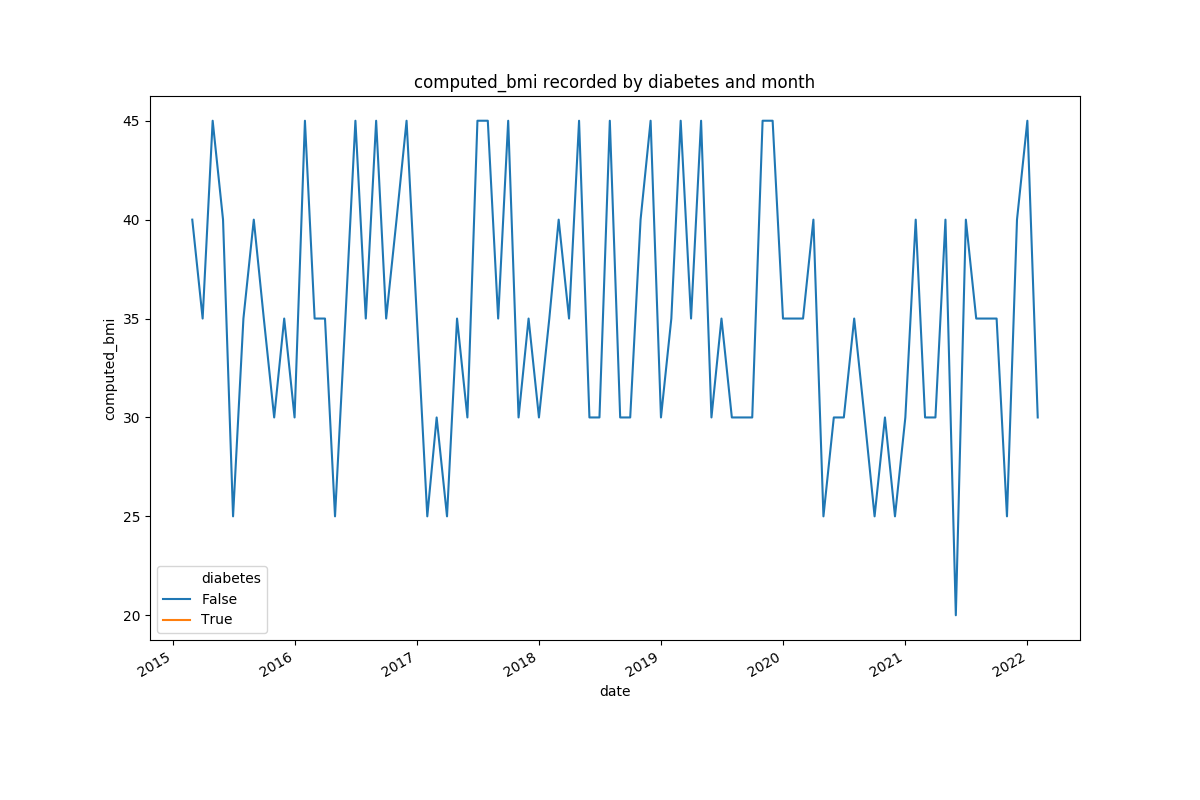

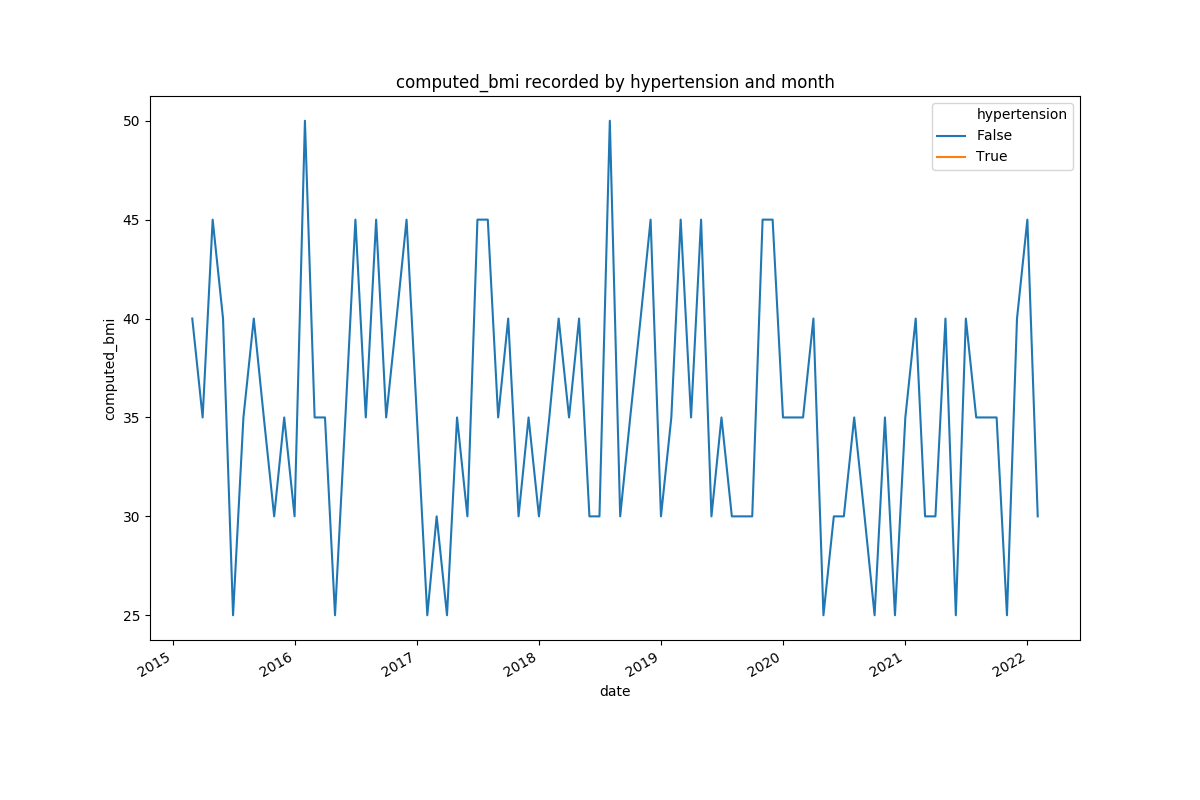

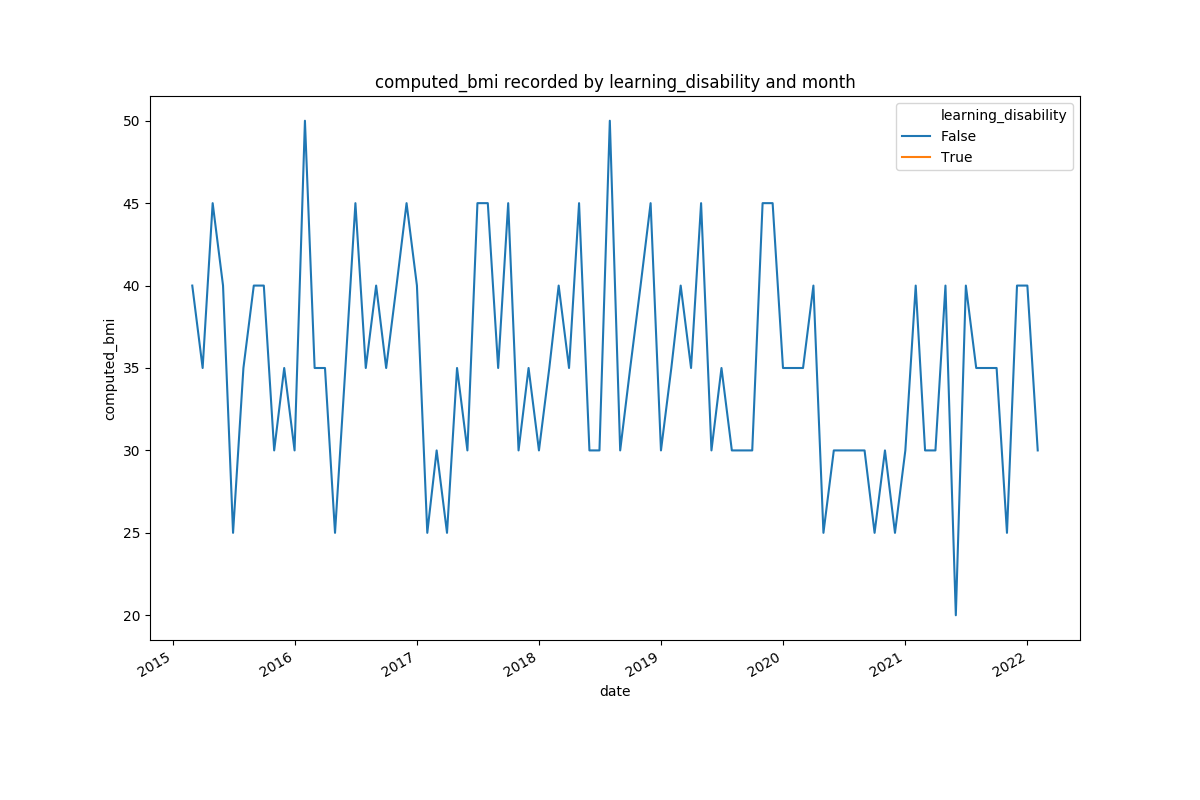

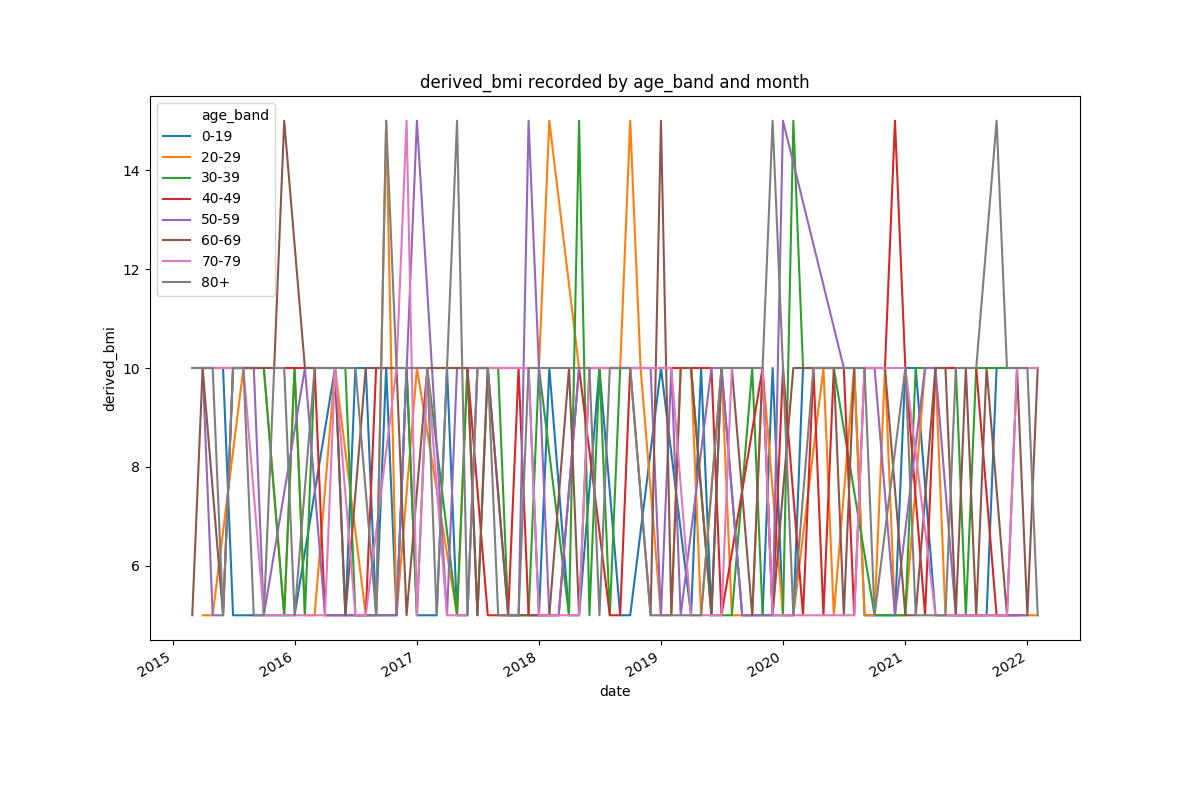

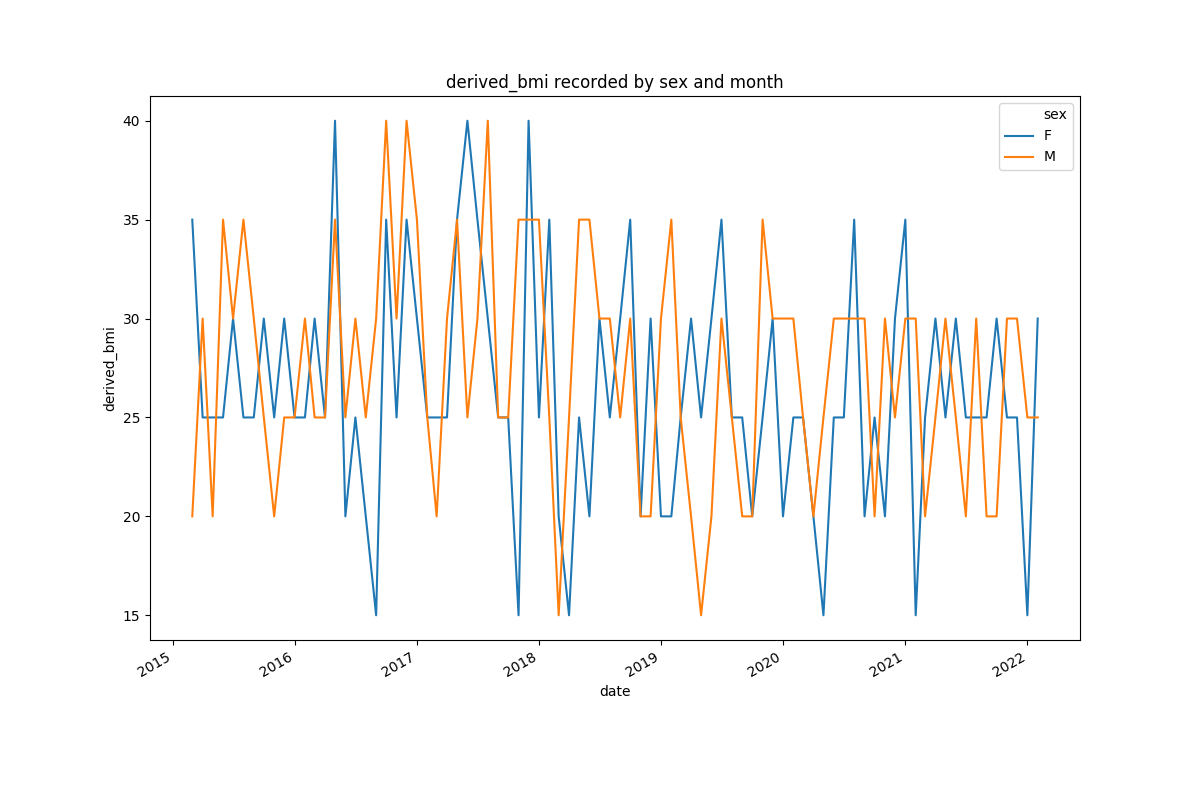

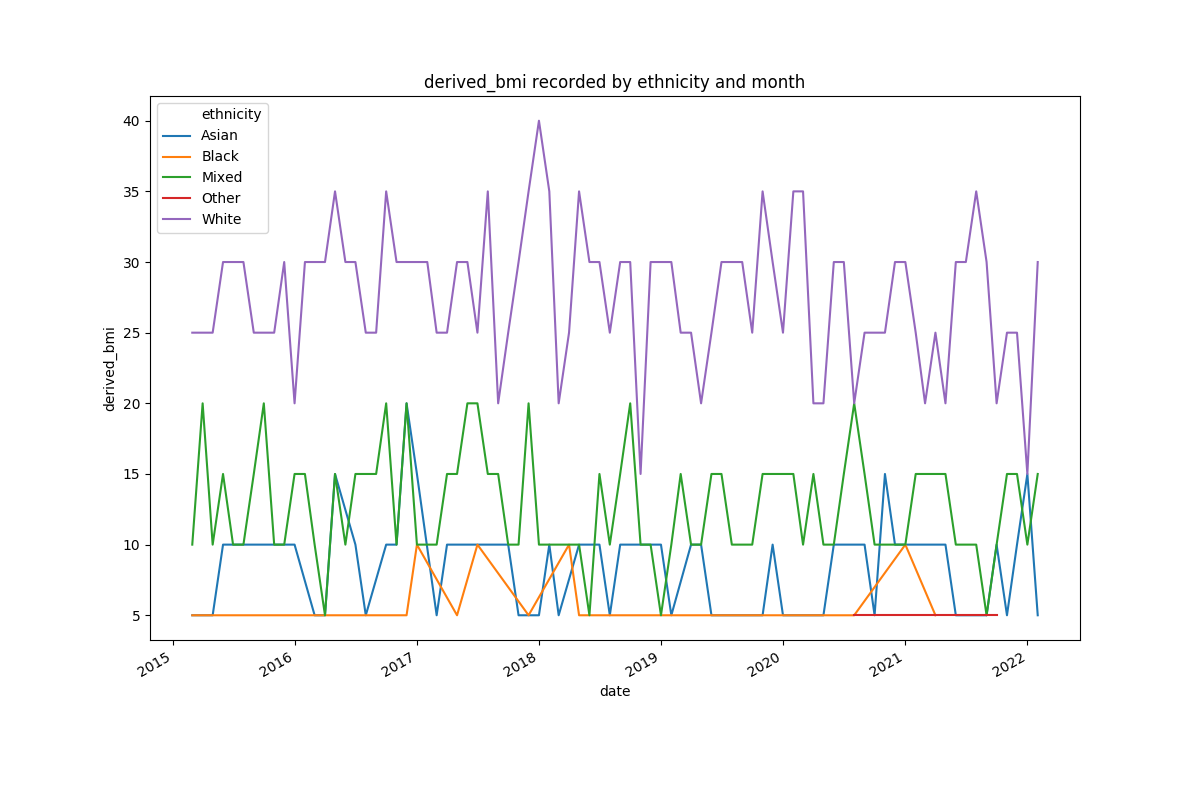

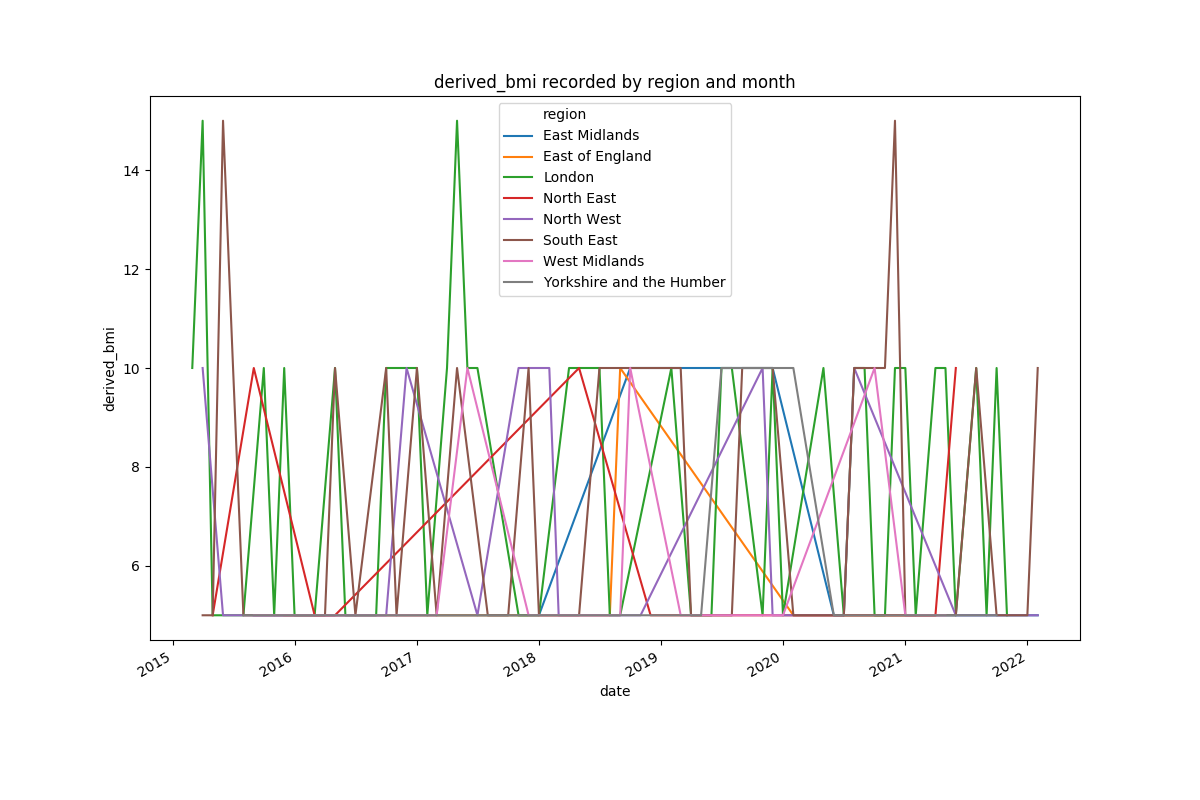

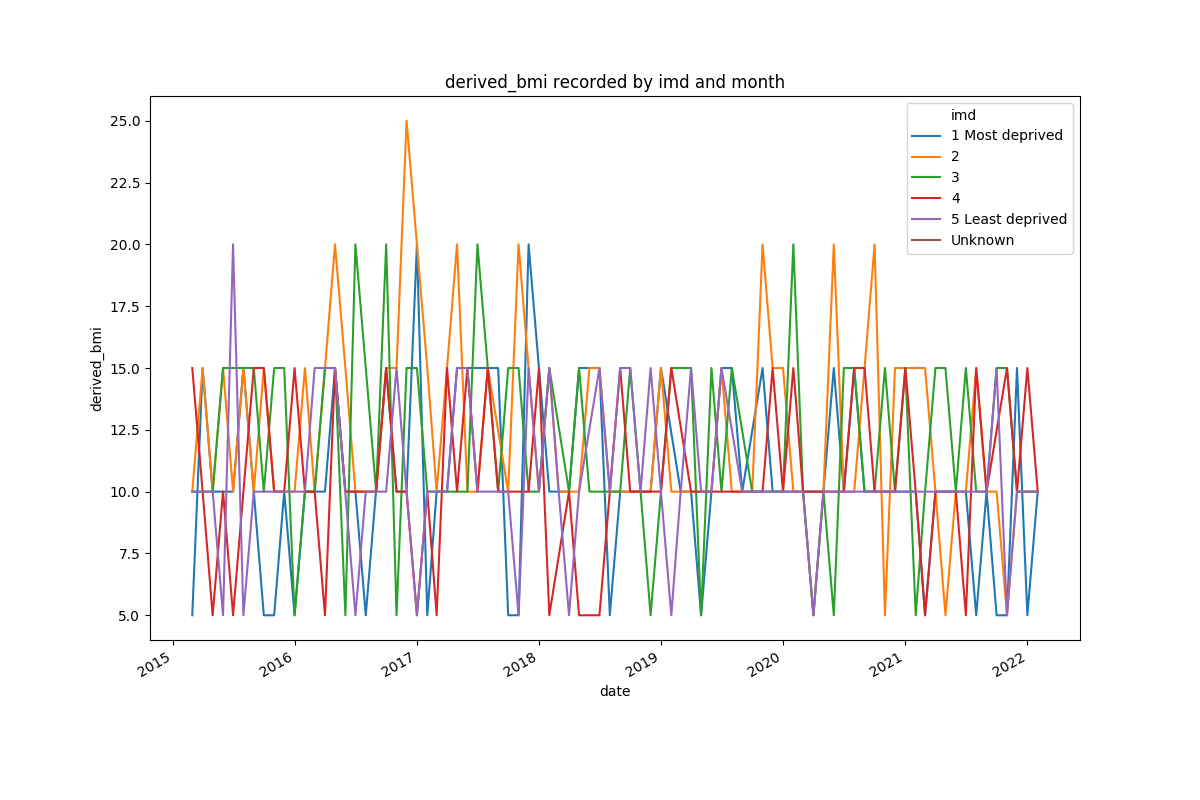

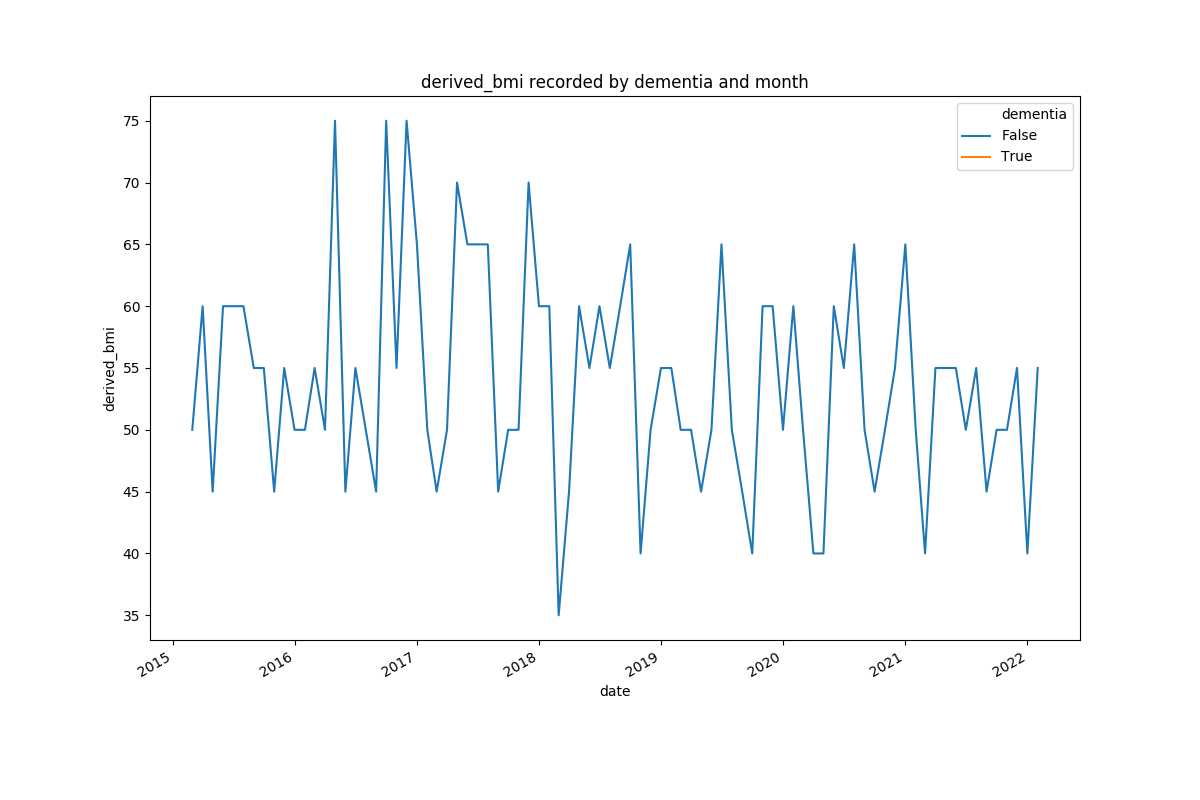

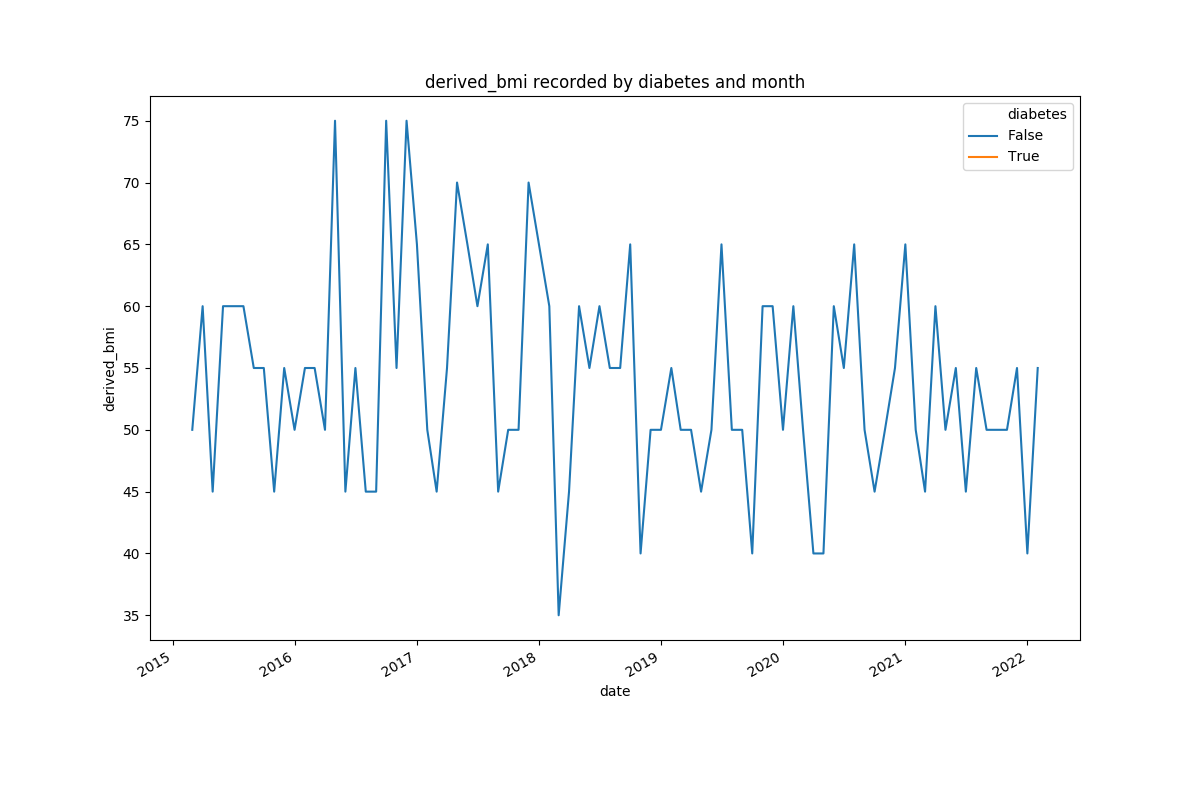

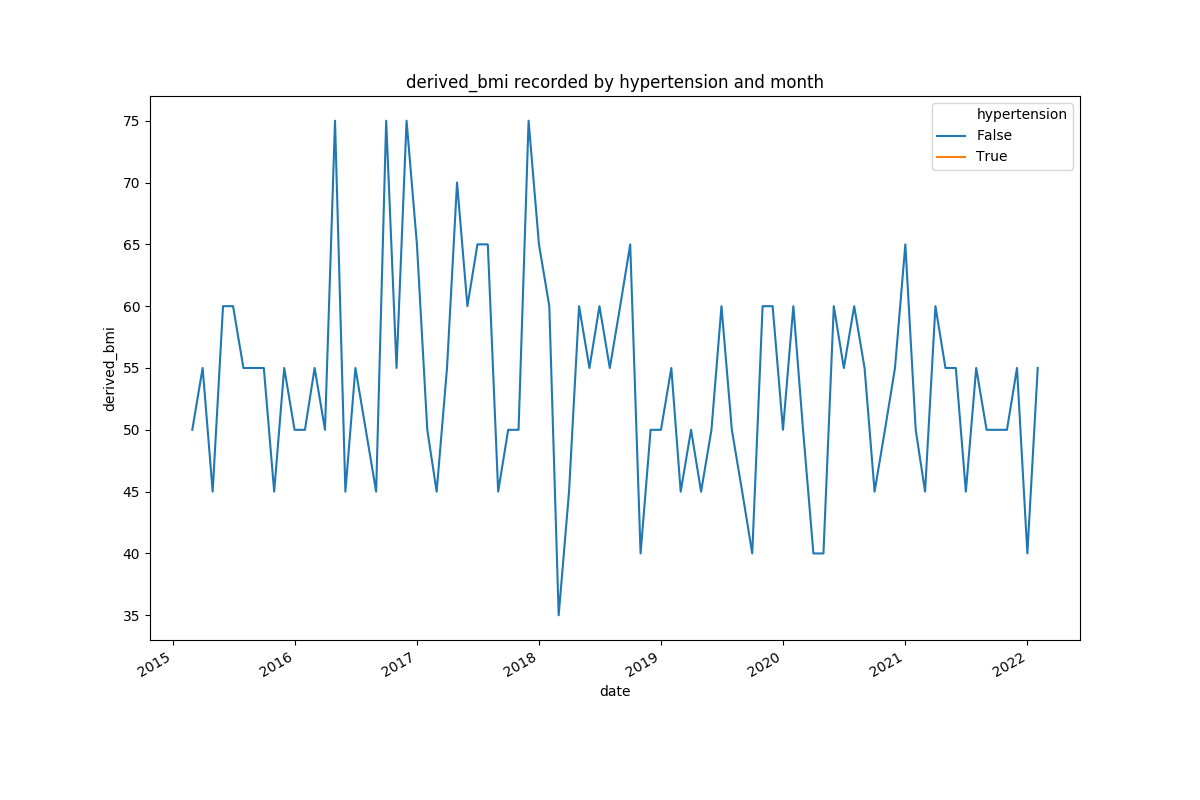

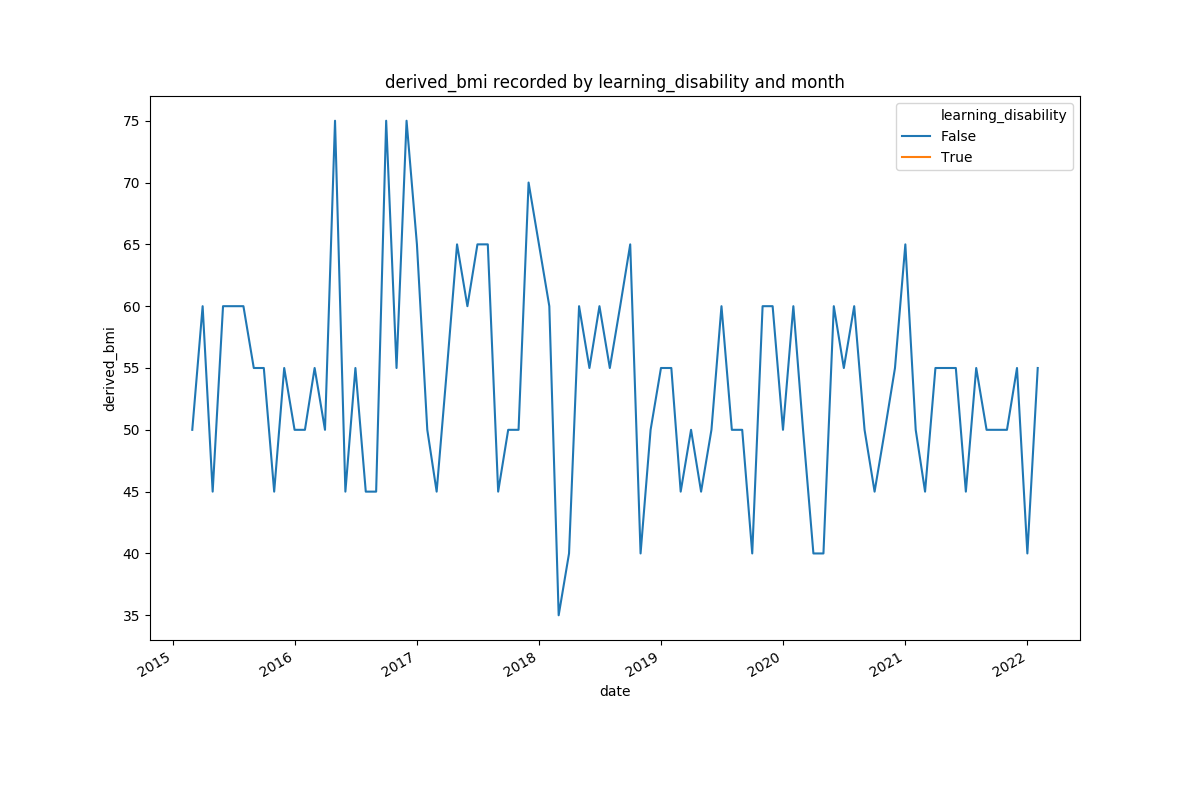

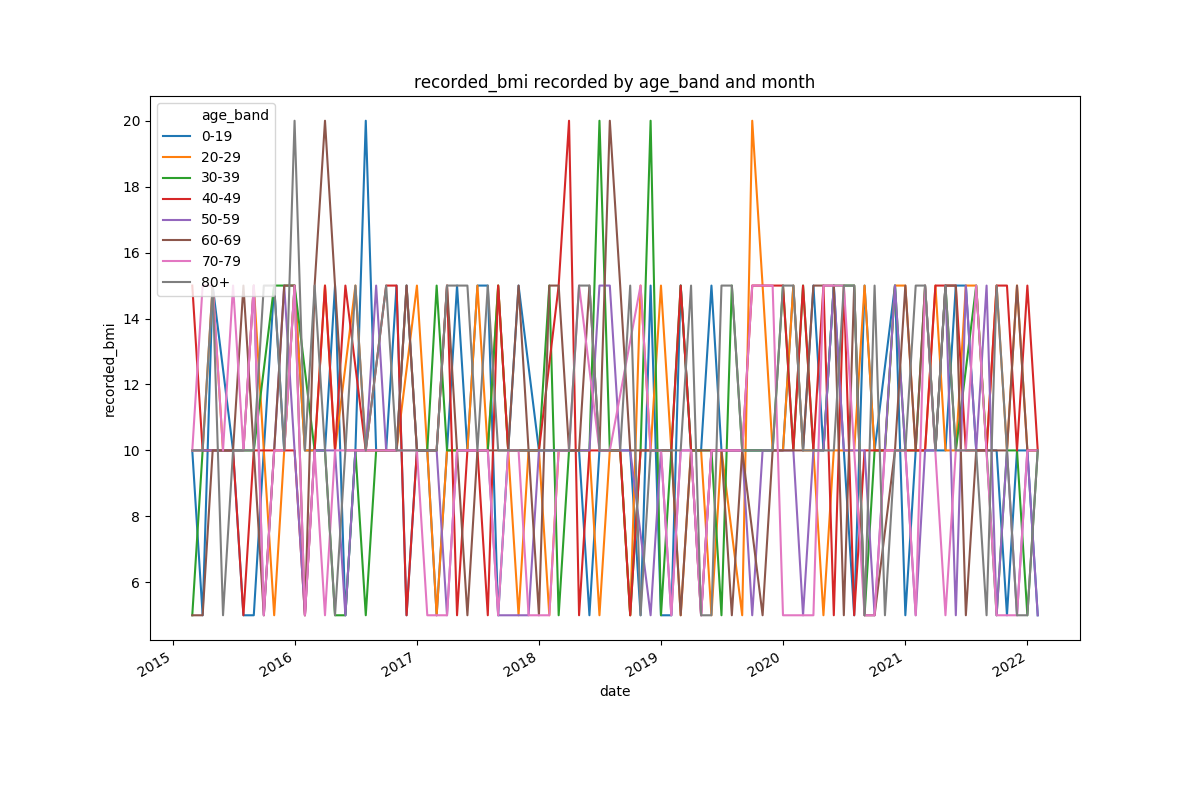

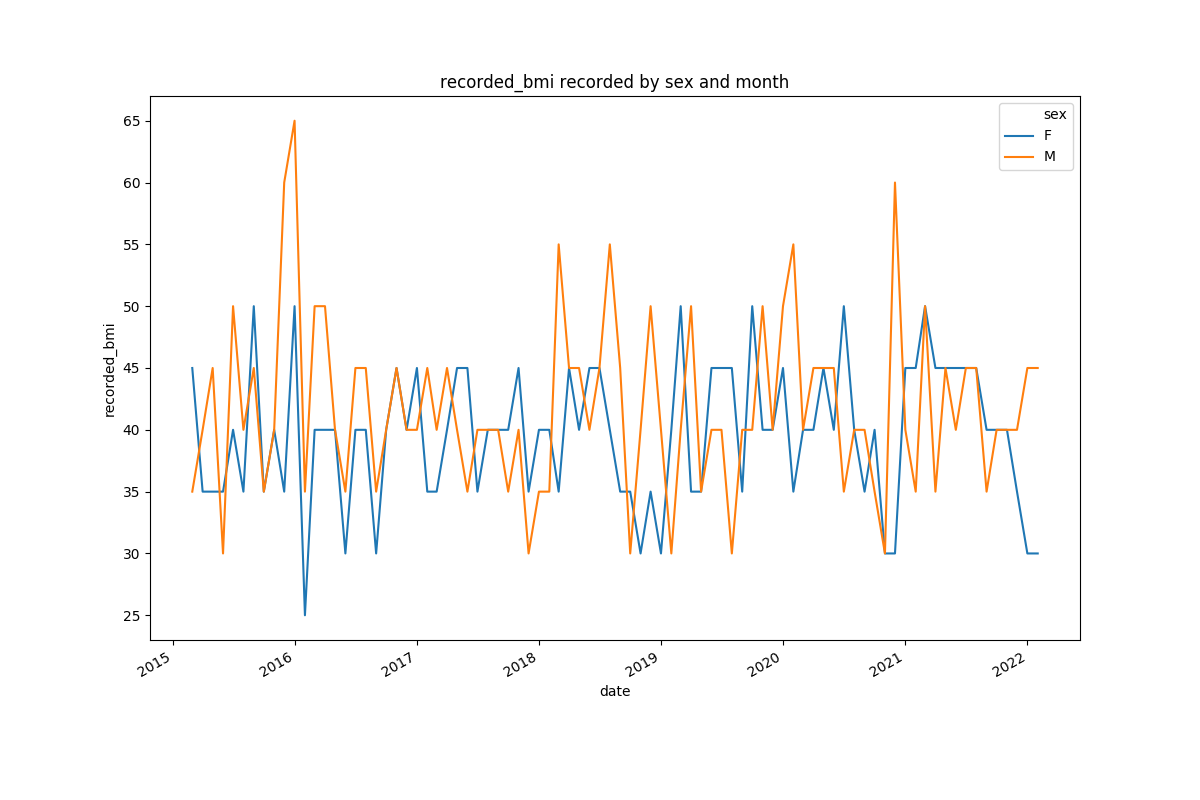

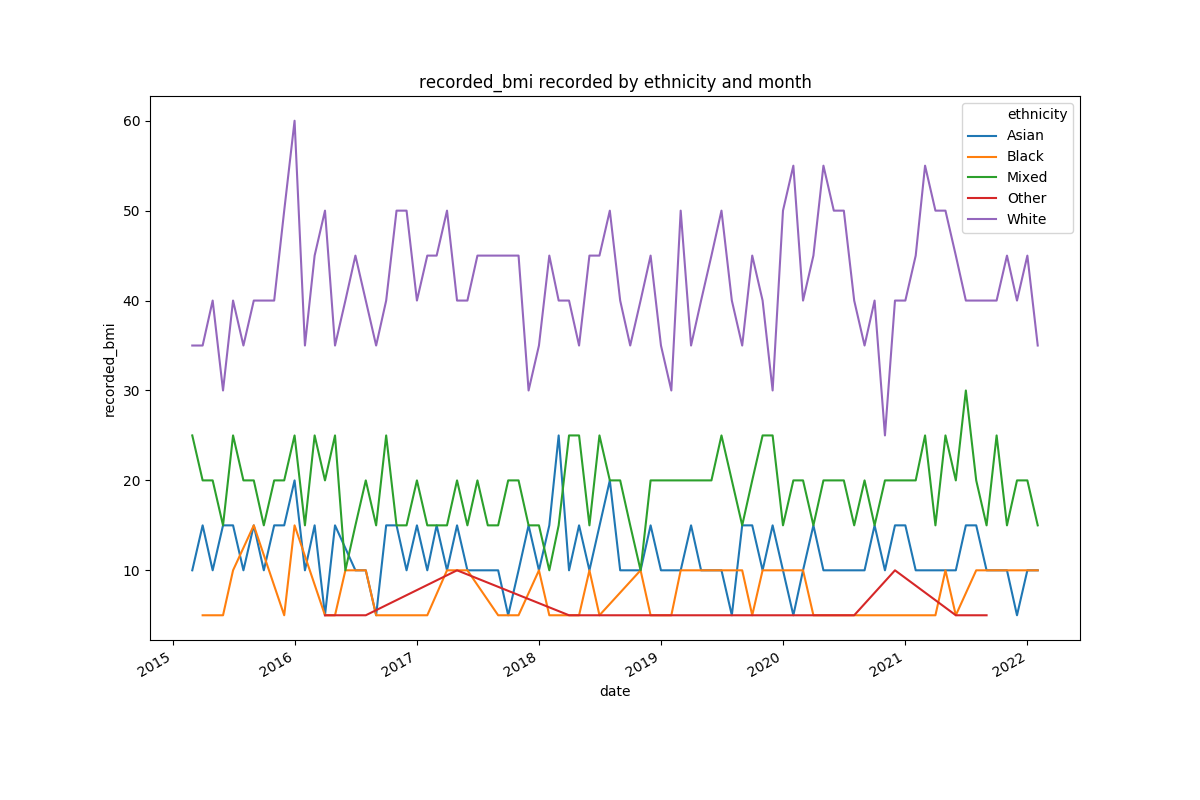

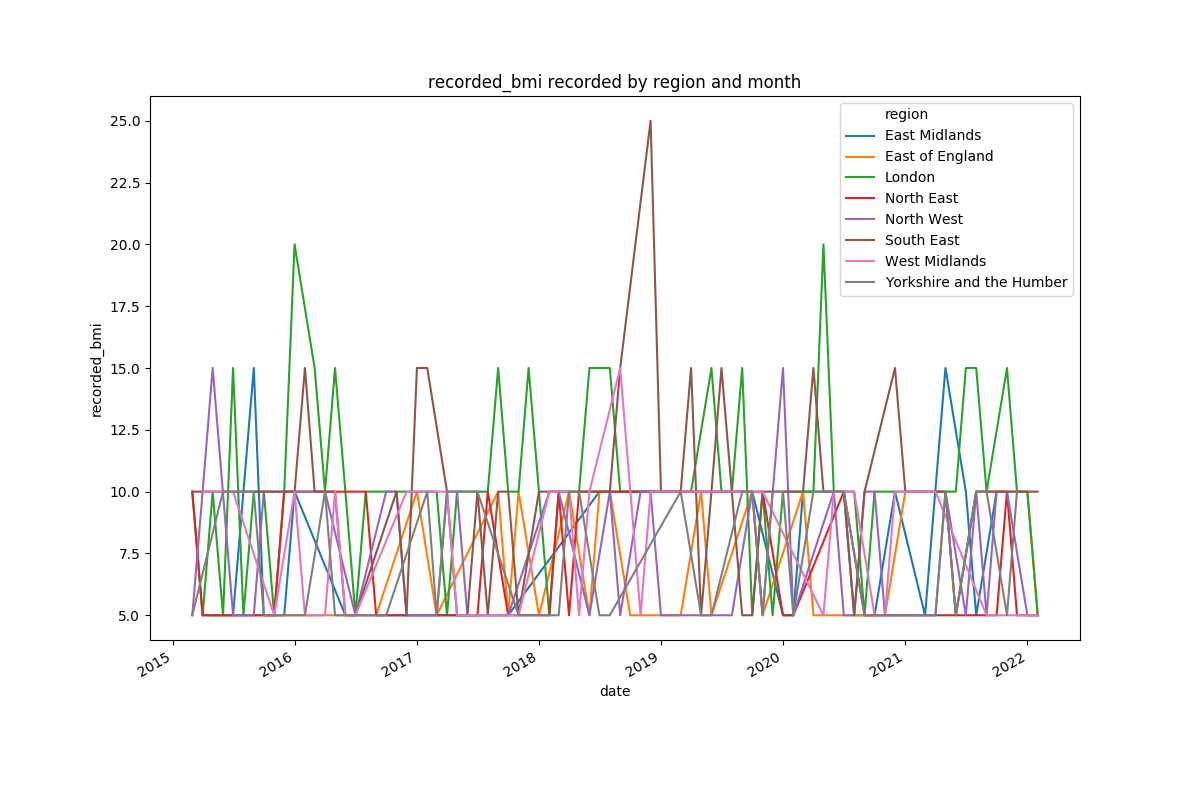

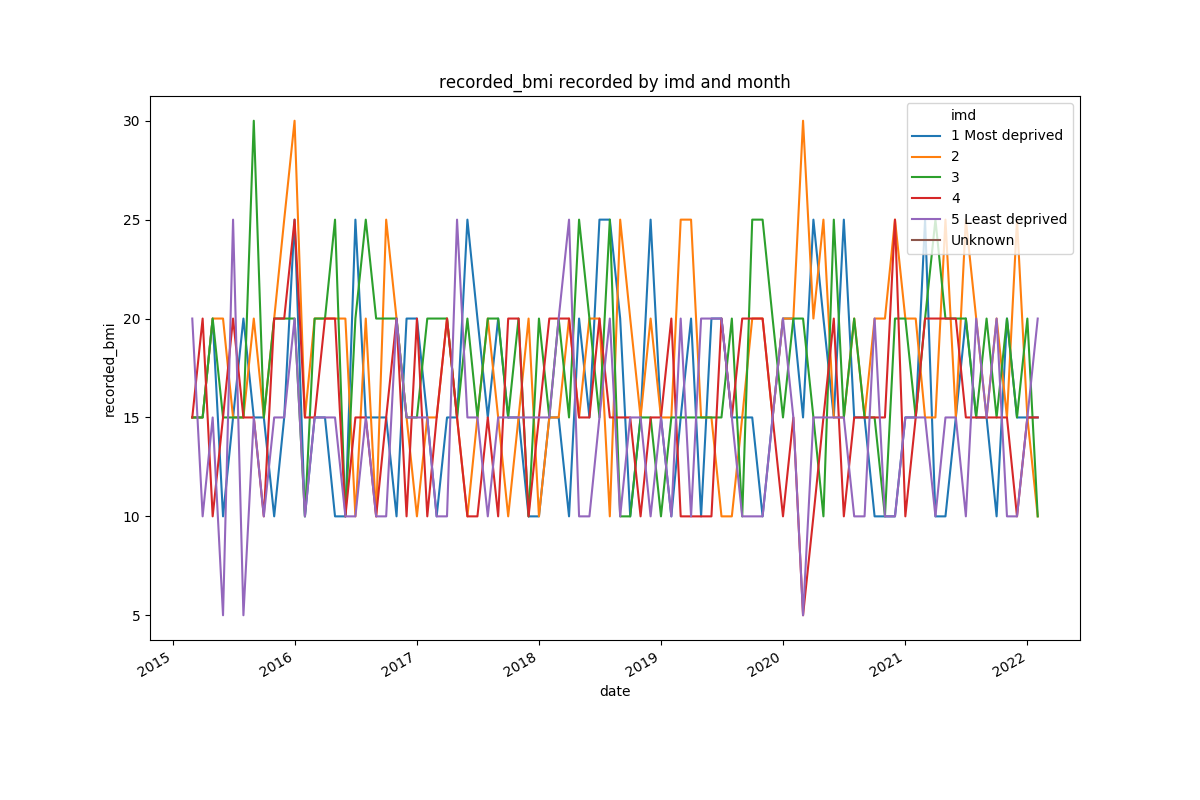

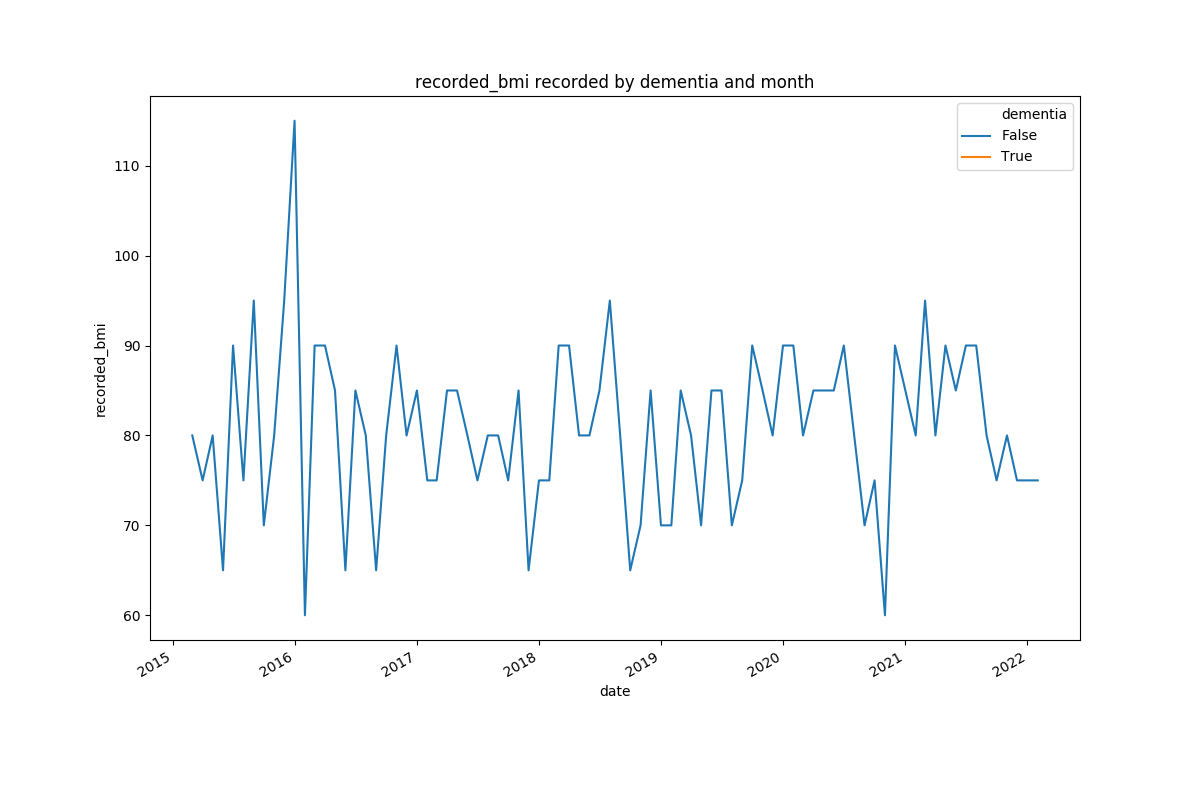

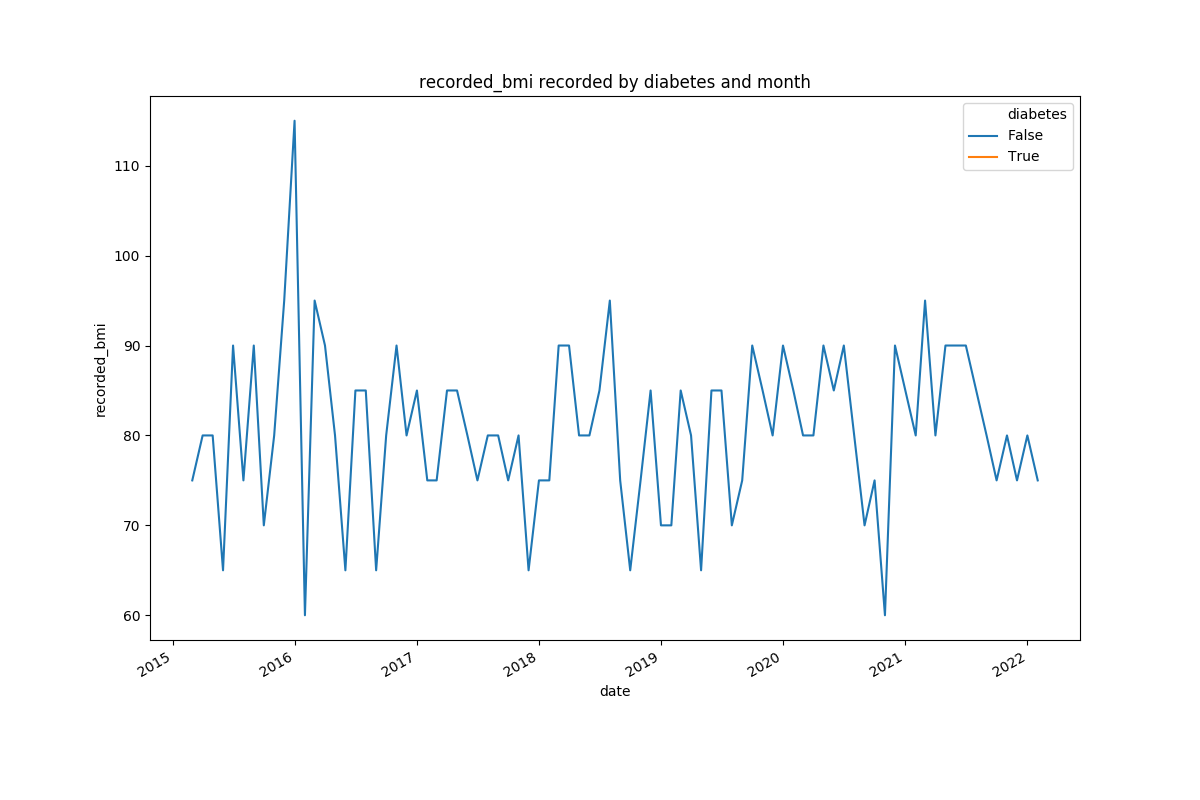

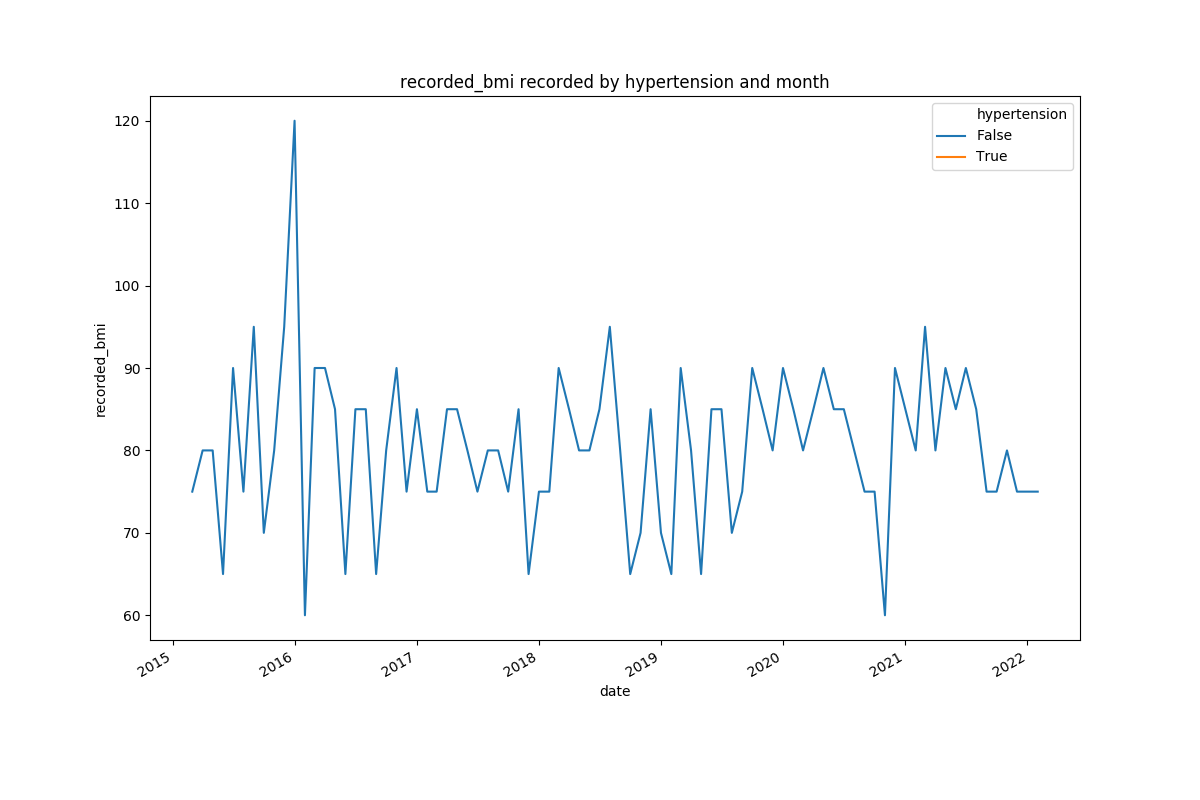

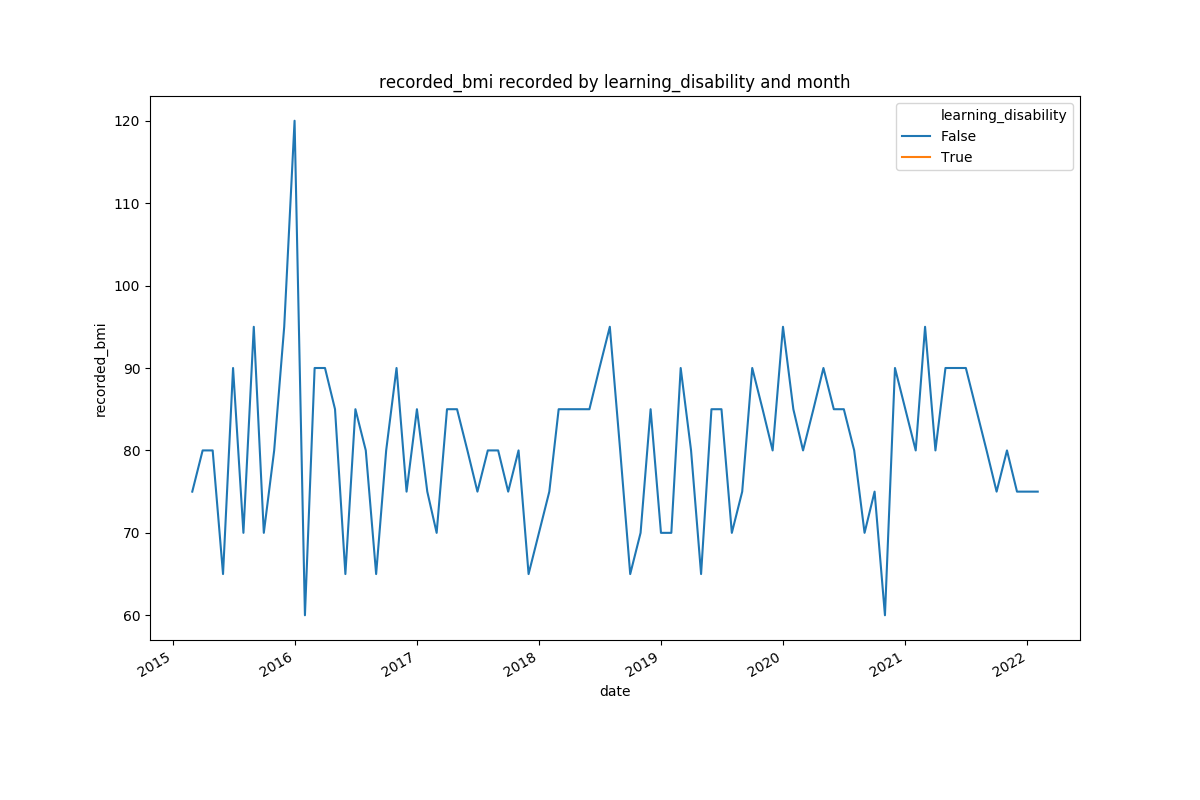

In [8]:
display(Image(f'../output/{output_path}/figures/records_over_time.png'))
for definition in definitions:
    for suffix in covariates: 
        display(Image(f'../output/{output_path}/figures/records_over_time_{definition}{suffix}.png'))

### Average Time Between Updates

avg_diff  count
date_diff_backend_bmi   17.905020   2030
date_diff_computed_bmi  17.955379   2015
date_diff_derived_bmi   14.273617   3580
date_diff_recorded_bmi  10.430672   5850

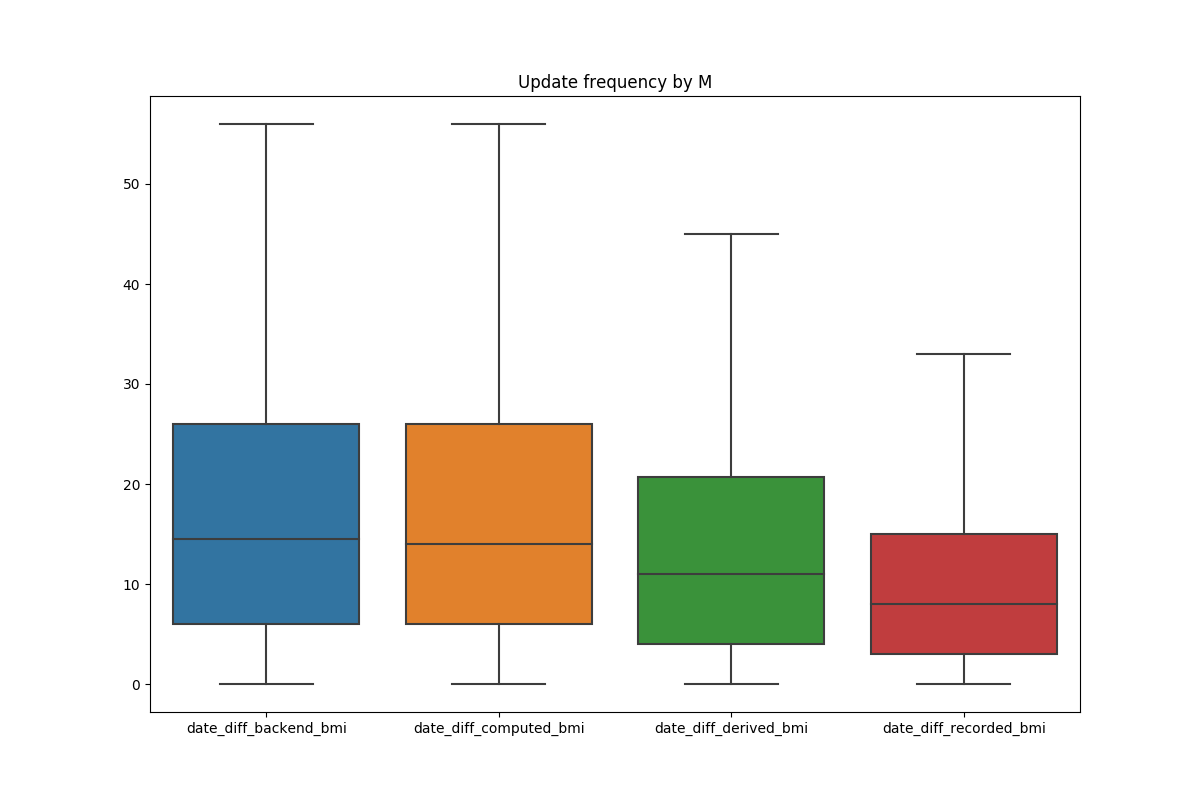

avg_date_diff_backend_bmi  avg_date_diff_computed_bmi  \
age_band                                                          
0-19                      17.262548                   16.040650   
20-29                     18.143969                   18.492754   
30-39                     17.976190                   17.829694   
40-49                     18.172794                   18.065306   
50-59                     19.545455                   19.340807   
60-69                     17.286344                   18.187713   
70-79                     17.781250                   17.908257   
80+                       17.270968                   17.808362   

          avg_date_diff_derived_bmi  avg_date_diff_recorded_bmi  \
age_band                                                          
0-19                      14.645783                   10.326389   
20-29                     14.015054                   10.943347   
30-39                     13.735892                   10.168707   
40-49                     14.636971                   10.214865   
50-59                     14.768496                   10.123033   
60-69                     13.922465                   10.312336   
70-79                     13.627604                   10.633956   
80+                       14.790000                   10.699495   

          ct_date_diff_backend_bmi  ct_date_diff_computed_bmi  \
age_band                                                        
0-19                           260                        245   
20-29                          255                        275   
30-39                          250                        230   
40-49                          270                        245   
50-59                          230                        225   
60-69                          225                        295   
70-79                          225                        220   
80+                            310                        285   

          ct_date_diff_derived_bmi  ct_date_diff_recorded_bmi  
age_band                                                       
0-19                           415                        720  
20-29                          465                        760  
30-39                          445                        735  
40-49                          450                        740  
50-59                          420                        700  
60-69                          505                        760  
70-79                          385                        640  
80+                            500                        790

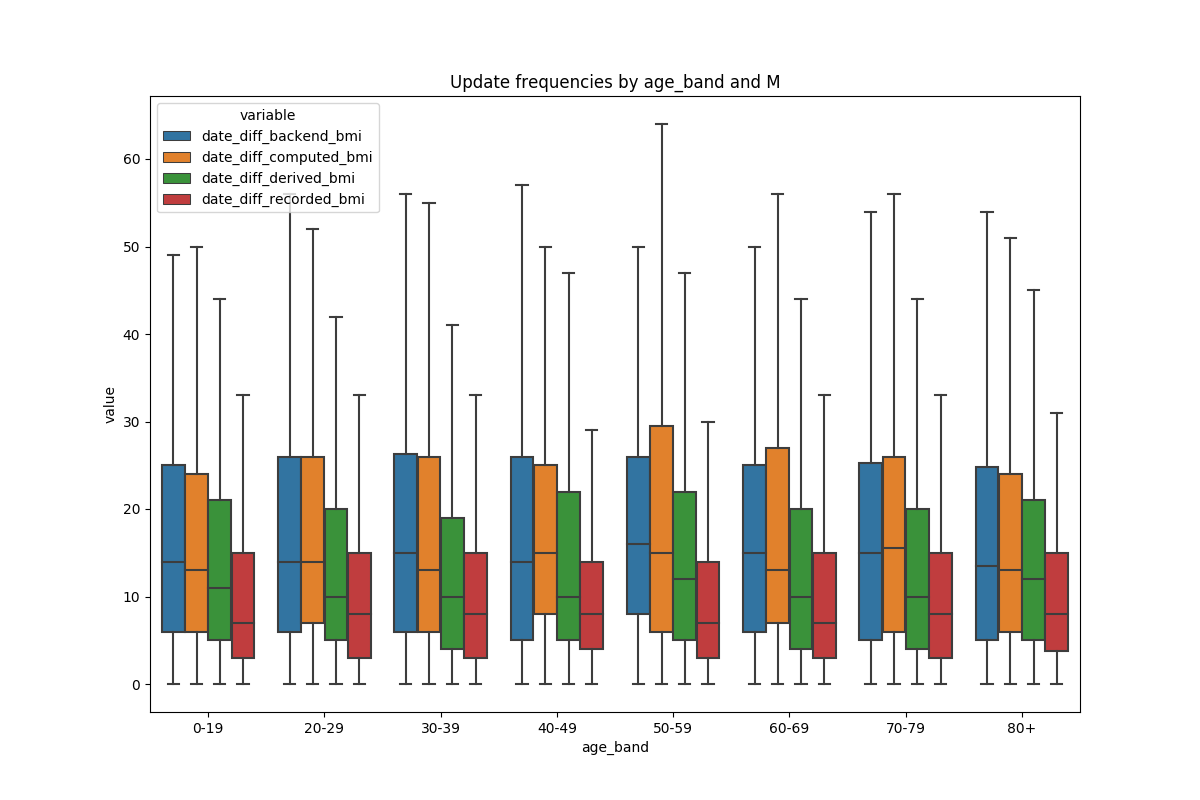

avg_date_diff_backend_bmi  avg_date_diff_computed_bmi  \
sex                                                          
F                    17.764408                   17.740206   
M                    18.038351                   18.154728   

     avg_date_diff_derived_bmi  avg_date_diff_recorded_bmi  \
sex                                                          
F                    14.046207                   10.259233   
M                    14.492055                   10.592814   

     ct_date_diff_backend_bmi  ct_date_diff_computed_bmi  \
sex                                                        
F                         990                        970   
M                        1045                       1045   

     ct_date_diff_derived_bmi  ct_date_diff_recorded_bmi  
sex                                                       
F                        1755                       2845  
M                        1825                       3005

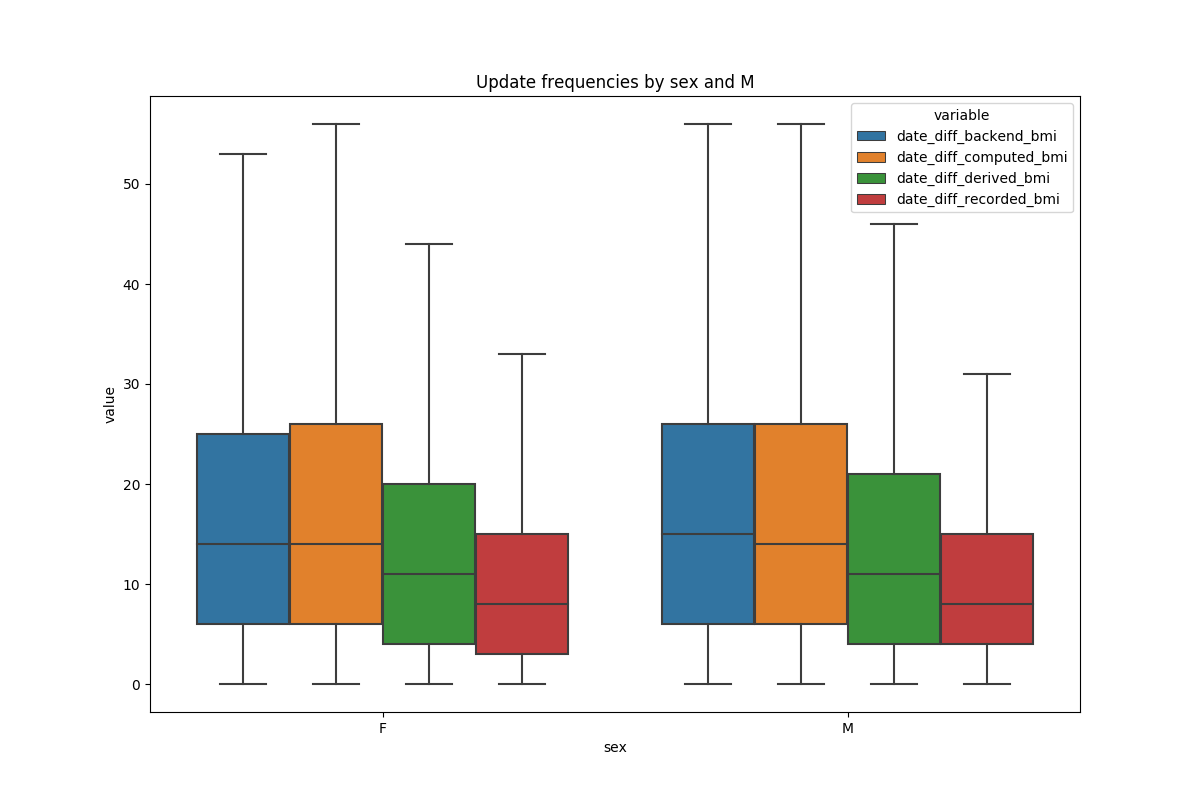

avg_date_diff_backend_bmi  avg_date_diff_computed_bmi  \
ethnicity                                                          
Asian                      16.652318                   17.727575   
Black                      17.574324                   17.612903   
Mixed                      18.414938                   17.894094   
Other                      20.328358                   19.428571   
White                      17.923524                   18.023669   

           avg_date_diff_derived_bmi  avg_date_diff_recorded_bmi  \
ethnicity                                                          
Asian                      13.775137                   10.963009   
Black                      14.898305                    9.639640   
Mixed                      14.962056                   10.445906   
Other                      14.527027                   10.552036   
White                      14.014208                   10.388020   

           ct_date_diff_backend_bmi  ct_date_diff_computed_bmi  \
ethnicity                                                        
Asian                           300                        300   
Black                           150                        155   
Mixed                           480                        490   
Other                            65                         55   
White                          1035                       1015   

           ct_date_diff_derived_bmi  ct_date_diff_recorded_bmi  
ethnicity                                                       
Asian                           545                        810  
Black                           235                        445  
Mixed                           815                       1370  
Other                           150                        220  
White                          1830                       3005

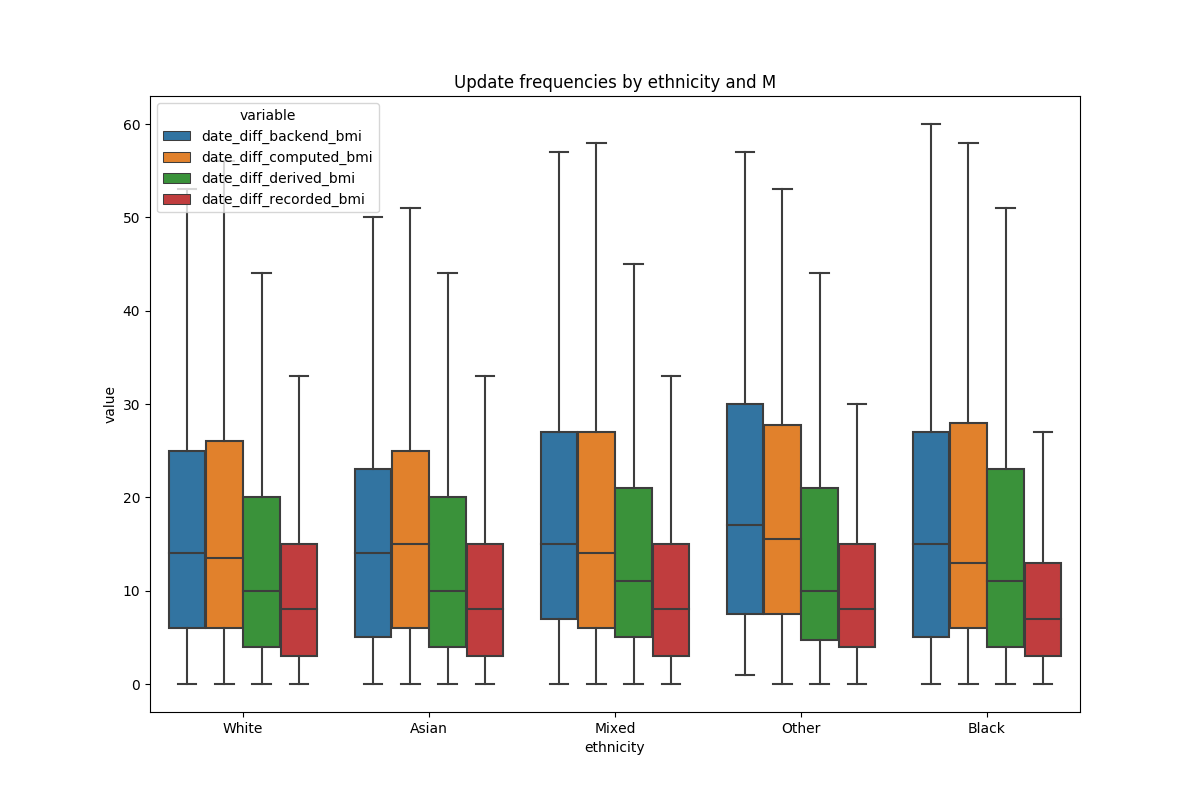

avg_date_diff_backend_bmi  \
region                                                
East Midlands                             19.152000   
East of England                           17.971831   
London                                    16.781818   
North East                                18.828829   
North West                                18.131944   
South East                                17.004310   
West Midlands                             17.935484   
Yorkshire and the Humber                  18.091549   

                          avg_date_diff_computed_bmi  \
region                                                 
East Midlands                              18.080000   
East of England                            17.691781   
London                                     19.084034   
North East                                 15.529412   
North West                                 17.164706   
South East                                 17.179039   
West Midlands                              16.050725   
Yorkshire and the Humber                   19.715232   

                          avg_date_diff_derived_bmi  \
region                                                
East Midlands                             14.764706   
East of England                           13.872247   
London                                    13.816092   
North East                                15.263158   
North West                                13.535714   
South East                                15.401575   
West Midlands                             13.775591   
Yorkshire and the Humber                  13.301158   

                          avg_date_diff_recorded_bmi  \
region                                                 
East Midlands                              10.530184   
East of England                            10.052925   
London                                     10.543056   
North East                                 10.266497   
North West                                 10.335443   
South East                                 10.373418   
West Midlands                              10.594527   
Yorkshire and the Humber                   11.017073   

                          ct_date_diff_backend_bmi  ct_date_diff_computed_bmi  \
region                                                                          
East Midlands                                  125                        125   
East of England                                140                        145   
London                                         275                        240   
North East                                     110                        135   
North West                                     145                        170   
South East                                     230                        230   
West Midlands                                  155                        140   
Yorkshire and the Humber                       140                        150   

                          ct_date_diff_derived_bmi  ct_date_diff_recorded_bmi  
region                                                                         
East Midlands                                  220                        380  
East of England                                225                        360  
London                                         435                        720  
North East                                     230                        395  
North West                                     310                        475  
South East                                     380                        630  
West Midlands                                  255                        400  
Yorkshire and the Humber                       260                        410

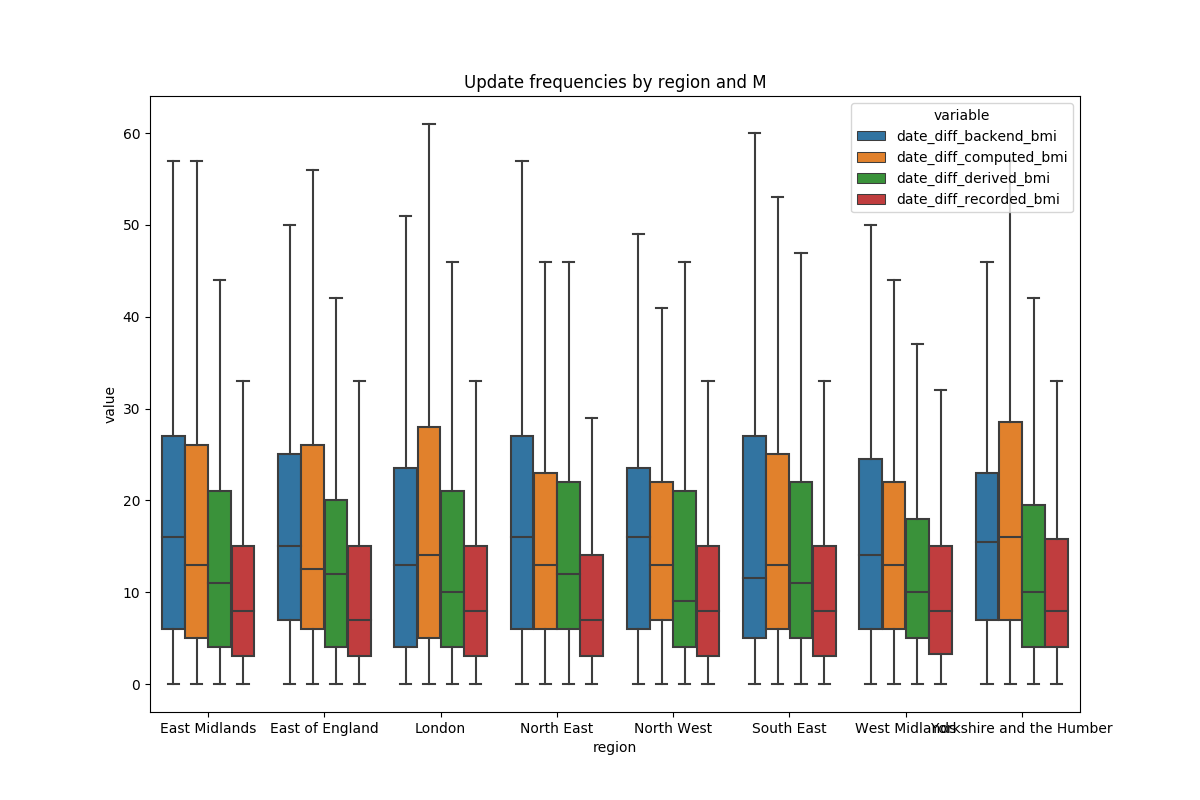

avg_date_diff_backend_bmi  avg_date_diff_computed_bmi  \
imd                                                                       
1 Most deprived                   17.518779                   17.502451   
2                                 18.657957                   18.988399   
3                                 18.000000                   17.748359   
4                                 16.774436                   16.920680   
5 Least deprived                  18.776163                   18.469027   
Unknown                           15.952381                   18.827586   

                  avg_date_diff_derived_bmi  avg_date_diff_recorded_bmi  \
imd                                                                       
1 Most deprived                   14.438806                   10.350831   
2                                 14.235897                   10.398734   
3                                 14.340561                   10.376190   
4                                 15.115269                   10.567568   
5 Least deprived                  13.225705                   10.404550   
Unknown                           13.552632                   11.655738   

                  ct_date_diff_backend_bmi  ct_date_diff_computed_bmi  \
imd                                                                     
1 Most deprived                        425                        410   
2                                      420                        430   
3                                      420                        455   
4                                      400                        355   
5 Least deprived                       345                        340   
Unknown                                 20                         30   

                  ct_date_diff_derived_bmi  ct_date_diff_recorded_bmi  
imd                                                                    
1 Most deprived                        670                       1145  
2                                      780                       1265  
3                                      785                       1260  
4                                      670                       1110  
5 Least deprived                       640                       1010  
Unknown                                 40                         60

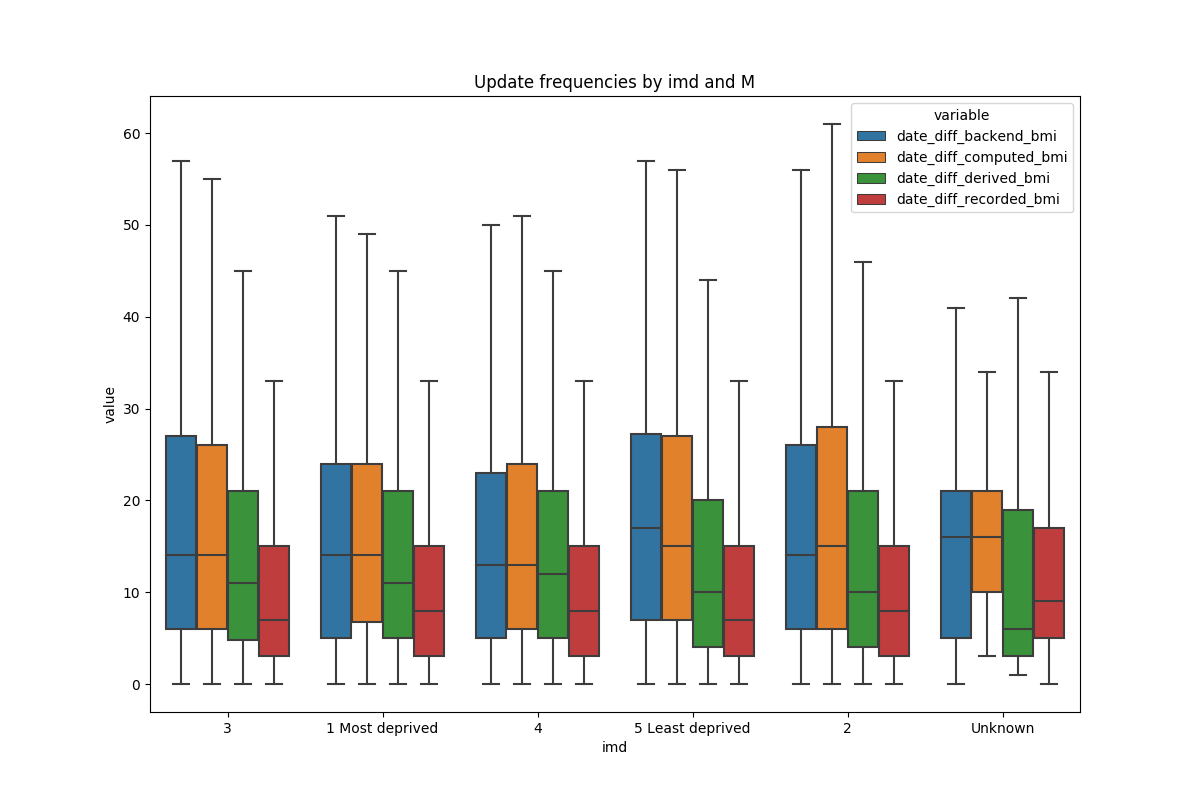

avg_date_diff_backend_bmi  avg_date_diff_computed_bmi  \
dementia                                                          
False                     17.907601                   17.913413   
True                      17.631579                   22.368421   

          avg_date_diff_derived_bmi  avg_date_diff_recorded_bmi  \
dementia                                                          
False                     14.296526                   10.425367   
True                      12.081081                   11.000000   

          ct_date_diff_backend_bmi  ct_date_diff_computed_bmi  \
dementia                                                        
False                         2015                       2000   
True                            20                         20   

          ct_date_diff_derived_bmi  ct_date_diff_recorded_bmi  
dementia                                                       
False                         3540                       5795  
True                            35                         55

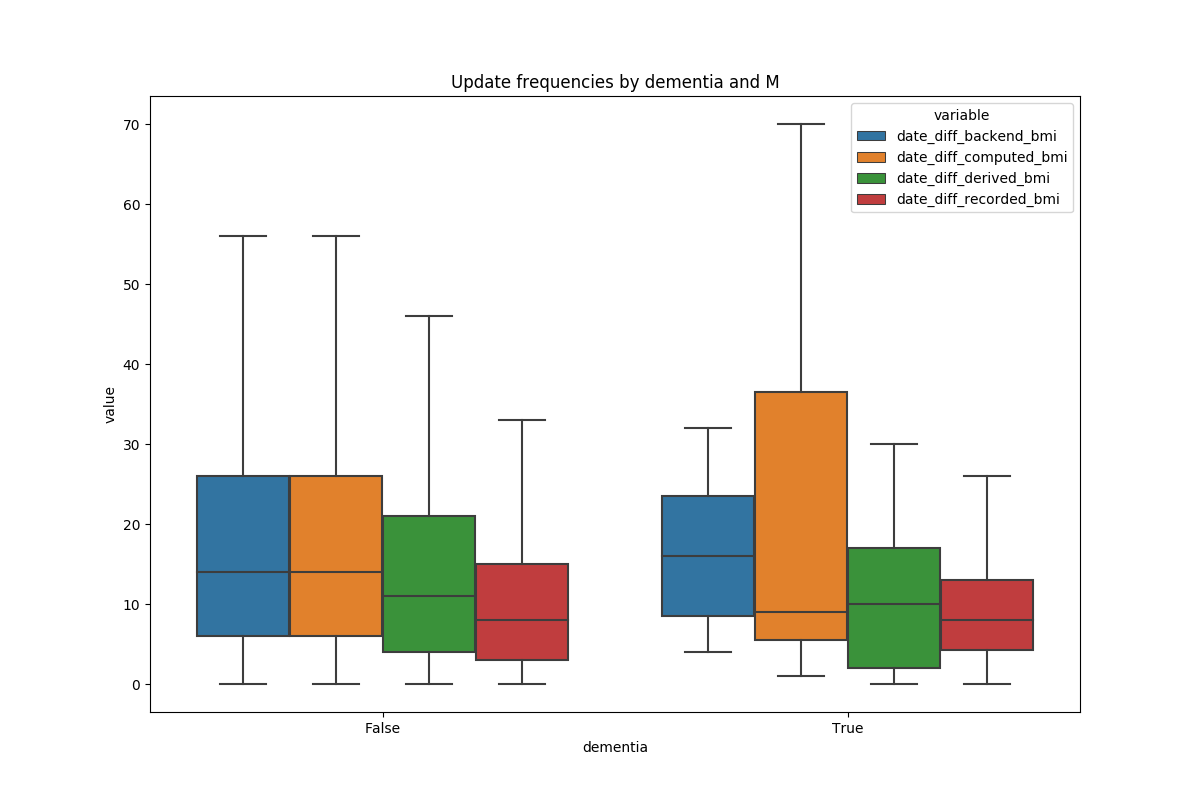

avg_date_diff_backend_bmi  avg_date_diff_computed_bmi  \
diabetes                                                          
False                     17.927897                   18.006507   
True                      15.714286                   12.578947   

          avg_date_diff_derived_bmi  avg_date_diff_recorded_bmi  \
diabetes                                                          
False                     14.258164                   10.454970   
True                      16.384615                    8.234375   

          ct_date_diff_backend_bmi  ct_date_diff_computed_bmi  \
diabetes                                                        
False                         2010                       2000   
True                            20                         20   

          ct_date_diff_derived_bmi  ct_date_diff_recorded_bmi  
diabetes                                                       
False                         3550                       5785  
True                            25                         65

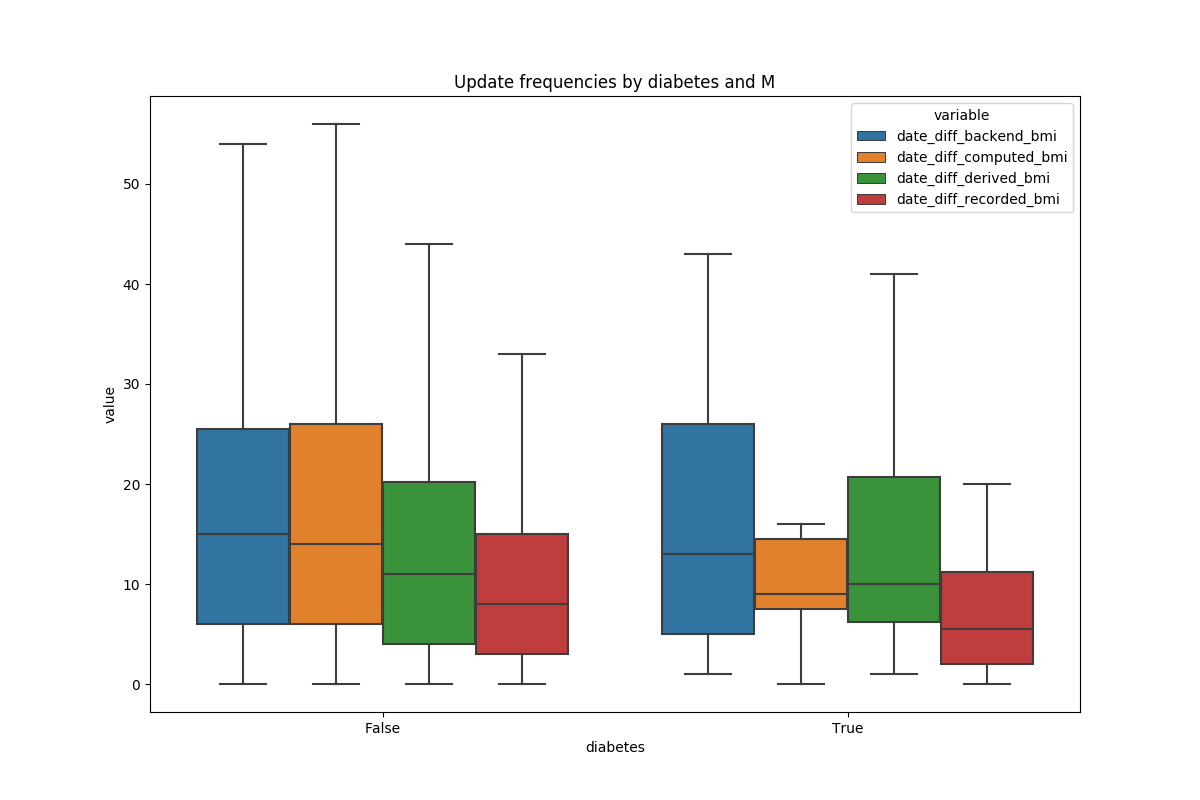

avg_date_diff_backend_bmi  avg_date_diff_computed_bmi  \
hypertension                                                          
False                         17.910626                   17.902402   
True                          17.277778                   23.526316   

              avg_date_diff_derived_bmi  avg_date_diff_recorded_bmi  \
hypertension                                                          
False                         14.289266                   10.432199   
True                          12.815789                   10.283333   

              ct_date_diff_backend_bmi  ct_date_diff_computed_bmi  \
hypertension                                                        
False                             2015                       2000   
True                                20                         20   

              ct_date_diff_derived_bmi  ct_date_diff_recorded_bmi  
hypertension                                                       
False                             3540                       5790  
True                                40                         60

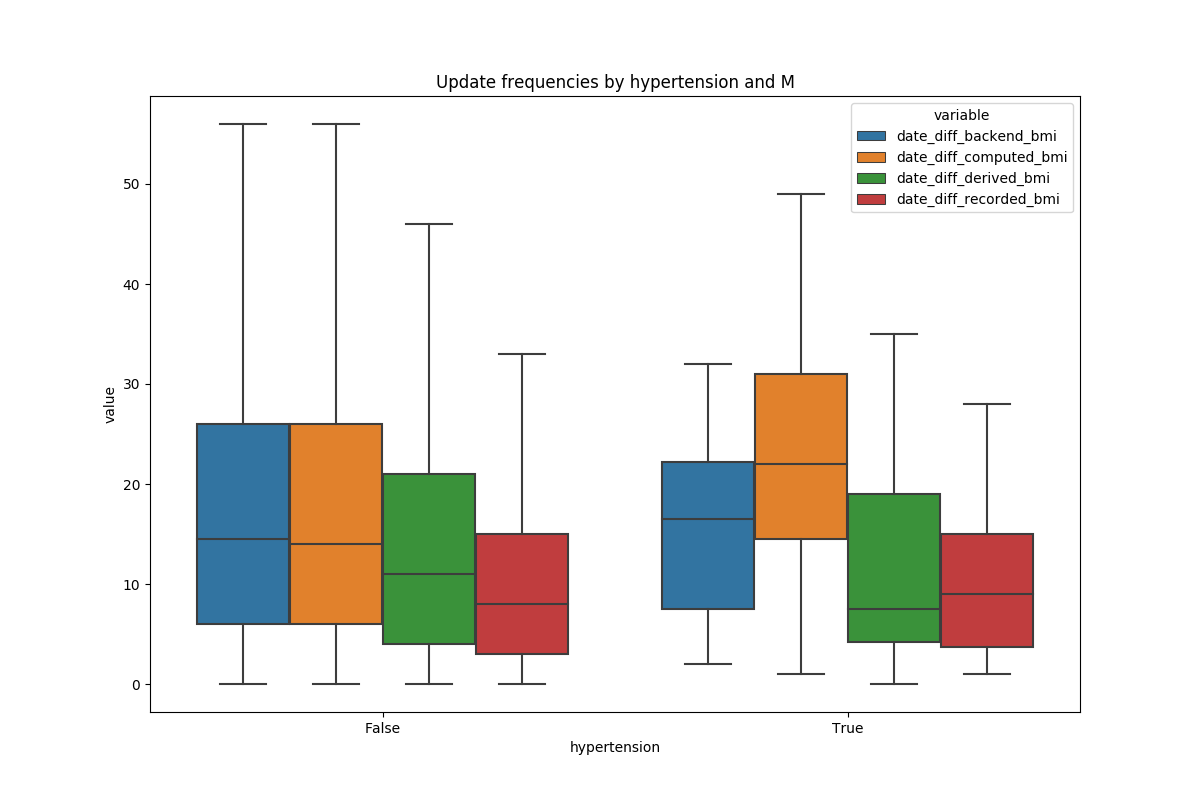

avg_date_diff_backend_bmi  avg_date_diff_computed_bmi  \
learning_disability                                                          
False                                17.933532                   17.836826   
True                                 14.312500                   36.230769   

                     avg_date_diff_derived_bmi  avg_date_diff_recorded_bmi  \
learning_disability                                                          
False                                14.267852                   10.427634   
True                                 14.857143                   10.728814   

                     ct_date_diff_backend_bmi  ct_date_diff_computed_bmi  \
learning_disability                                                        
False                                    2015                       2005   
True                                       15                         15   

                     ct_date_diff_derived_bmi  ct_date_diff_recorded_bmi  
learning_disability                                                       
False                                    3545                       5790  
True                                       35                         60

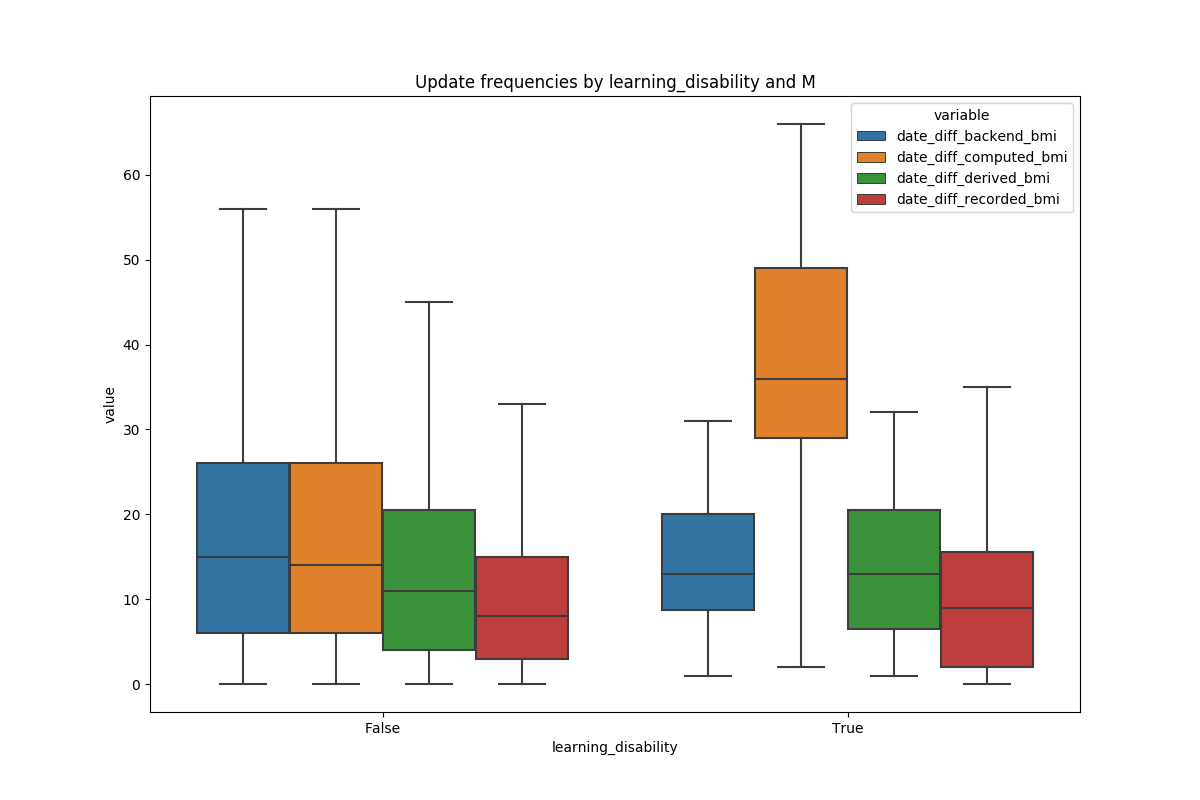

In [9]:
for suffix in ['','_age_band','_sex','_ethnicity','_region','_imd',
               '_dementia','_diabetes','_hypertension','_learning_disability']: 
    df_update = pd.read_csv(f'../output/{output_path}/tables/avg_update_frequency{suffix}.csv', index_col=0)
    display(df_update)
    
    img_exist = os.path.exists(f'../output/{output_path}/figures/avg_update_frequency{suffix}.png')
    
    if img_exist:
        img_update = Image(f'../output/{output_path}/figures/avg_update_frequency{suffix}.png')
        display(img_update)
    else: 
        print('Plot redacted due to low counts.')